In [9]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# # Use only the first GPU (or specify another GPU index)
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [10]:
import tensorflow as tf
# allocate gpu memory incrementally for multiple trainings
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [11]:
# check if gpu RAM is released
gpus = tf.config.list_physical_devices('GPU')
try:
    for gpu in gpus:
        memory_info = tf.config.experimental.get_memory_info(gpu.name[-5:])
        print(f"GPU: {gpu.name}, Current Memory: {memory_info['current'] / (1024 ** 2)}, Peak Memory: {memory_info['peak'] / (1024 ** 2)}")
except RuntimeError as e:
        print(e)

GPU: /physical_device:GPU:0, Current Memory: 5814.075439453125, Peak Memory: 7368.958984375
GPU: /physical_device:GPU:1, Current Memory: 0.0, Peak Memory: 0.0


In [12]:
import psutil

# Get the available system memory in bytes
available_memory = psutil.virtual_memory().available

# Convert bytes to a more human-readable format (e.g., MB or GB)
available_memory_gb = available_memory / (1024 ** 3)  # Convert to GB

print(f"Available CPU RAM: {available_memory_gb:.2f} GB")


Available CPU RAM: 117.21 GB


In [13]:
from utils import find_repo_root, load_dict, calculate_vectorized_correlation, get_fmri, get_pca, correlation_metric, download_fmri
from evaluation_utils import run_evaluation_pipeline

from contextlib import contextmanager
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from numba import cuda
import multiprocessing
import gc
import pickle
from sklearn.preprocessing import StandardScaler
# import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, Nadam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import ParameterGrid

### Function Definitions

In [14]:
# @contextmanager
# def dummy_context_mgr():
#     """ A dummy context manager for use when no strategy is provided. """
#     yield

def train_model(layer, sub, ROI, X_train, X_val, y_train, y_val, hp_combinations, strategy, visualize_results=True):
    """
    conducts the training for a particular input layer of the CNN, subject & ROI. saves model.
    :param X_train: training data (feature map PCs from first 800 videos from a particular layer)
    :param X_val: validation data (feature map PCs from videos 801-900 from a particular layer)
    :param y_train: training labels (scans for first 800 videos for the particular subject & ROI)
    :param y_val: training labels (scans for videos 801-900 for the particular subject & ROI)
    :param hp_combinations: dict with all parameter values in HPO. If hpo=False in run_training_pipeline, this only contains one single set of HP values
    :param visualize_results: whether training will be plotted
    :return: model parameters
    """
    print("y_train shape: ", y_train.shape)
    print("Y_val shape: ", y_val.shape)
    
    # apply training to every HP combination. If hpo == False, only one HP combination will be checked
    for hp_set in hp_combinations:
        
        # save all HP values of current iteration as variable
        num_hidden_layers = hp_set["num_hidden_layers"]
        l2_reg = hp_set["l2_reg"]
        learning_rate = hp_set["learning_rate"]
        dropout = hp_set["dropout"]
        num_epochs = hp_set["num_epochs"]
        
        # specify number of neurons per layer, depending on the number of inputs from a particular layer and number of output voxels
        # leads to symmetric funnel-like shape of the network, with increasing layer sizes for WB and decreasing size for all ROIs
        if num_hidden_layers == 1:
            input_neurons = X_train.shape[1]
            hidden1_neurons = y_train.shape[1] + (X_train.shape[1] - y_train.shape[1])*(1/2)
            output_neurons = y_train.shape[1]
        elif num_hidden_layers == 2:
            input_neurons = X_train.shape[1]
            hidden1_neurons = y_train.shape[1] + (X_train.shape[1] - y_train.shape[1])*(2/3)
            hidden2_neurons = y_train.shape[1] + (X_train.shape[1] - y_train.shape[1])*(1/3)
            output_neurons = y_train.shape[1]
      
        # model construction: 1 or 2 hidden layers. L2 Reg & Dropout.       
        # with strategy.scope() if strategy else dummy_context_mgr():
        if num_hidden_layers == 1:
            model = Sequential([
                Dense(hidden1_neurons, input_shape=(input_neurons,),
                      activation='relu', kernel_regularizer=l2(l2_reg)),
                Dropout(dropout),
                Dense(output_neurons, activation='linear',
                      kernel_regularizer=l2(l2_reg)),
                Dropout(dropout)
            ])
        elif num_hidden_layers == 2:
            model = Sequential([
                Dense(hidden1_neurons, input_shape=(input_neurons,),
                      activation='relu', kernel_regularizer=l2(l2_reg)),
                Dropout(dropout),
                Dense(hidden2_neurons, activation='relu',
                      kernel_regularizer=l2(l2_reg)),
                Dropout(dropout),
                Dense(output_neurons, activation='linear',
                      kernel_regularizer=l2(l2_reg)),
                Dropout(dropout)
            ])

        # early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

        # Compiling the model
        nadam = Nadam(learning_rate=learning_rate)
        model.compile(optimizer=nadam, loss='mean_squared_error')
        
        # Training the model
        history = model.fit(X_train, y_train,
                            epochs=num_epochs,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],
                            verbose=1)
        
        if visualize_results:
            # print layer overview
            print(model.summary())
            
            # Plot training & validation loss values
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('Model loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper left')
            plt.show()
        
#         # check if gpu RAM is released
#         gpus = tf.config.list_physical_devices('GPU')
#         try:
#             for gpu in gpus:
#                 memory_info = tf.config.experimental.get_memory_info(gpu.name[-5:])
#                 print(f"GPU: {gpu.name}, Current Memory: {memory_info['current'] // (1024 ** 2)} MB, Peak Memory: {memory_info['peak'] // (1024 ** 2)} MB")
#         except RuntimeError as e:
#                 print(e)
        
#         print("Clearing GPU RAM...")
#         device = cuda.get_current_device()
#         device.reset()
        
#         # check if gpu RAM is released
#         # Run a TensorFlow operation on the GPU to allocate memory
#         with tf.device('/GPU:0'):
#             a = tf.constant([1.0, 2.0, 3.0])
#             b = tf.constant([4.0, 5.0, 6.0])
#             c = a * b
        
#         gpus = tf.config.list_physical_devices('GPU')
#         try:
#             for gpu in gpus:
#                 memory_info = tf.config.experimental.get_memory_info(gpu.name[-5:])
#                 print(f"GPU: {gpu.name}, Current Memory: {memory_info['current'] / (1024 ** 2)}, Peak Memory: {memory_info['peak'] / (1024 ** 2)}")
#         except RuntimeError as e:
#                 print(e)
        
        # save the model in a new folder
        with tf.device('/CPU:0'):
            models_dir = os.path.join(os.getcwd(), "models", layer, ROI, sub)
            if not os.path.exists(models_dir):
                os.makedirs(models_dir)
            model_name = f"model_hidden_{num_hidden_layers}_lr_{learning_rate}_dropout_{dropout}_l2_{l2_reg}" + ".keras"
            model_path = os.path.join(models_dir, model_name)
            print("Saving model...")
            print(model_path)
            model.save(model_path)
            print("Model saved.")

            # save training history
            history_filename = model_name.replace('.keras', '.history')  # Replace the extension
            history_path = os.path.join(models_dir, history_filename)
            print("Saving training history...")
            with open(history_path, 'wb') as f:
                pickle.dump(history.history, f)
            print("Training history saved.")
                       
        print("Clearing the TensorFlow session...")
        tf.keras.backend.clear_session()
#         del model  # Delete the model or any large variables
#         gc.collect()  # Collect garbage
        


In [15]:
def run_training_pipeline(hpo=False, import_type="direct", strategy=None):
    """
    conducts training. Models will be saved in .keras format for evaluation.
    Parameters
    ----------
    hpo: if set to true, hyperparameter optimization will be conducted. Otherwise, a single set of hyperparameters will be applied. Adjust HP for that manually here.
    import_type: set to "direct" if the full PCA output from the main Resnet is directly loaded into the CWD.
                 set to "indirect" if a folder structure with one file per video is loaded.
    """
    # load one only one main PCA file into the Ucloud session. This will determine the layer
    layer_list = ["stage_1", "stage_2", "stage_3", "stage_4", "stage_5", "final"]
    for i in layer_list:
        if os.path.exists(f"{i}_pca.pkl") or os.path.exists(f"{i}_pca.npy"):
            layer = i
            break

    # filter out subs / ROIs manually in case not everything should be run
    # subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]
    subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]
    ROIs = ["V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"] # "WB", 
    
    # unless already downloaded, download the fmri data
    download_fmri()
    
    # Load activations (PCA outputs)
    train_pca,val_pca = get_pca(layer, mode="val", import_type=import_type)
    
    # specify hyperparameter grid
    # param_grid ={"learning_rate": [0.0001, 0.00001],
    #             "num_hidden_layers": [1,2],
    #             "dropout": [0.2, 0.3, 0.4, 0.5],
    #             "l2_reg":[0.001, 0.0001, 0.00001],
    #             "num_epochs": [100]}
    param_grid ={"learning_rate": [0.0001],
                "num_hidden_layers": [1,2],
                "dropout": [0.2, 0.4],
                "l2_reg":[0.001, 0.0001],
                "num_epochs": [100]}
    hp_combinations = ParameterGrid(param_grid)
    if hpo:
        # choose hp settings to test in current session
        hp_combinations = list(hp_combinations)[0:4]
    else:
        # if no HPO, specify hyperparameter settings manually here - one value per HP
        param_grid = {'learning_rate': [0.0001],
                      'num_hidden_layers': [2],
                      'dropout': [0.2],
                      'l2_reg': [0.0001],
                      'num_epochs': [100]}
        hp_combinations = ParameterGrid(param_grid)
        
    for sub in subs:
          for ROI in ROIs:
            print ("Starting ROI: ", ROI, "sub: ",sub)
                # Load fMRI data (labels)
            if ROI == "WB":
                  track="full_track"
            else:
                  track="mini_track"
            fmri_train, fmri_val= get_fmri(ROI, track, sub, mode="val")

            # model training
            # ToDo: add required changes for HPO to model training                        
            train_model(layer=layer,
                        sub=sub,
                        ROI=ROI,
                        X_train=train_pca,
                        X_val=val_pca,
                        y_train=fmri_train,
                        y_val=fmri_val,
                        hp_combinations=hp_combinations,
                        visualize_results=True,
                        strategy=strategy)

            print ("Completed ROI: ", ROI, "sub: ",sub)
            print("----------------------------------------------------------------------------")

### Run Training & Evaluation

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Data are already downloaded.


2024-01-17 20:48:15.981595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /device:GPU:0 with 38296 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2024-01-17 20:48:15.986964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /device:GPU:1 with 38296 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0


base_train shape:  (800, 5625)
base_val shape:  (100, 5625)
motion_train shape:  (800, 3136)
motion_val shape:  (100, 3136)
Starting ROI:  V1 sub:  sub01
ROI_train shape:  (800, 232)
ROI_val shape:  (100, 232)
y_train shape:  (800, 232)
Y_val shape:  (100, 232)
Epoch 1/100
 6/25 [======>.......................] - ETA: 0s - loss: 1.9664

2024-01-17 20:48:18.011095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 8.00GiB (8589934592 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-17 20:48:18.013561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 7.20GiB (7730940928 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-17 20:48:18.015578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 6.48GiB (6957846528 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-17 20:48:18.017527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 5.83GiB (6262061568 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-17 20:48:18.019490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 5.25GiB (5635855360 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-17 20:48:18.021502: I 

25/25 [==============================] - 2s 34ms/step - loss: 1.6433 - val_loss: 1.3244
Epoch 2/100
25/25 [==============================] - 1s 26ms/step - loss: 1.2947 - val_loss: 1.2598
Epoch 3/100
25/25 [==============================] - 1s 27ms/step - loss: 1.2152 - val_loss: 1.2124
Epoch 4/100
25/25 [==============================] - 1s 27ms/step - loss: 1.1584 - val_loss: 1.1762
Epoch 5/100
25/25 [==============================] - 1s 25ms/step - loss: 1.1111 - val_loss: 1.1483
Epoch 6/100
25/25 [==============================] - 1s 26ms/step - loss: 1.0698 - val_loss: 1.1264
Epoch 7/100
25/25 [==============================] - 1s 29ms/step - loss: 1.0366 - val_loss: 1.1083
Epoch 8/100
25/25 [==============================] - 1s 27ms/step - loss: 1.0084 - val_loss: 1.0931
Epoch 9/100
25/25 [==============================] - 1s 25ms/step - loss: 0.9857 - val_loss: 1.0790
Epoch 10/100
25/25 [==============================] - 1s 27ms/step - loss: 0.9662 - val_loss: 1.0661
Epoch 11/10

25/25 [==============================] - 0s 13ms/step - loss: 0.2037 - val_loss: 0.3794
Epoch 83/100
25/25 [==============================] - 0s 13ms/step - loss: 0.1988 - val_loss: 0.3751
Epoch 84/100
25/25 [==============================] - 0s 14ms/step - loss: 0.1939 - val_loss: 0.3709
Epoch 85/100
25/25 [==============================] - 0s 14ms/step - loss: 0.1894 - val_loss: 0.3685
Epoch 86/100
25/25 [==============================] - 0s 13ms/step - loss: 0.1854 - val_loss: 0.3629
Epoch 87/100
25/25 [==============================] - 0s 13ms/step - loss: 0.1821 - val_loss: 0.3598
Epoch 88/100
25/25 [==============================] - 0s 13ms/step - loss: 0.1774 - val_loss: 0.3561
Epoch 89/100
25/25 [==============================] - 0s 13ms/step - loss: 0.1740 - val_loss: 0.3525
Epoch 90/100
25/25 [==============================] - 0s 13ms/step - loss: 0.1711 - val_loss: 0.3489
Epoch 91/100
25/25 [==============================] - 0s 14ms/step - loss: 0.1675 - val_loss: 0.3458
Epo

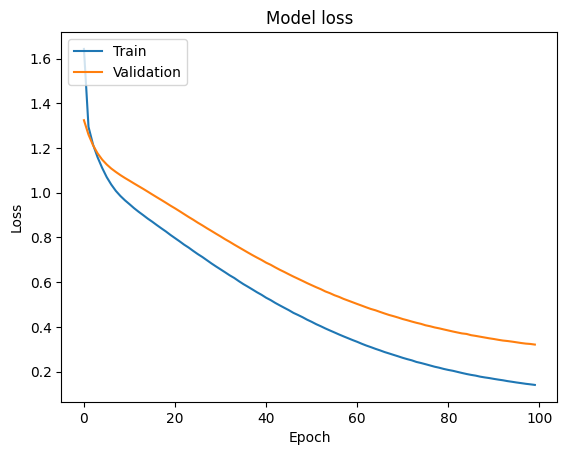

Saving model...
/home/mawf/brainvision/bv_training_stage_5/models/stage_5/V1/sub01/model_hidden_2_lr_0.0001_dropout_0.2_l2_0.0001.keras
Model saved.
Saving training history...
Training history saved.
Clearing the TensorFlow session...
Completed ROI:  V1 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub01
ROI_train shape:  (800, 231)
ROI_val shape:  (100, 231)
y_train shape:  (800, 231)
Y_val shape:  (100, 231)
Epoch 1/100
25/25 [==============================] - 2s 31ms/step - loss: 1.6424 - val_loss: 1.3261
Epoch 2/100
25/25 [==============================] - 1s 28ms/step - loss: 1.2992 - val_loss: 1.2619
Epoch 3/100
25/25 [==============================] - 1s 28ms/step - loss: 1.2215 - val_loss: 1.2141
Epoch 4/100
25/25 [==============================] - 1s 28ms/step - loss: 1.1652 - val_loss: 1.1772
Epoch 5/100
25/25 [==============================] - 1s 28ms/step - loss: 1.1167 - val_loss: 1.1488
Epoch 6/100
25/25 [

25/25 [==============================] - 1s 26ms/step - loss: 0.2312 - val_loss: 0.4004
Epoch 78/100
25/25 [==============================] - 1s 27ms/step - loss: 0.2263 - val_loss: 0.3955
Epoch 79/100
25/25 [==============================] - 1s 29ms/step - loss: 0.2210 - val_loss: 0.3908
Epoch 80/100
25/25 [==============================] - 1s 25ms/step - loss: 0.2156 - val_loss: 0.3854
Epoch 81/100
25/25 [==============================] - 1s 30ms/step - loss: 0.2109 - val_loss: 0.3818
Epoch 82/100
25/25 [==============================] - 1s 25ms/step - loss: 0.2062 - val_loss: 0.3768
Epoch 83/100
25/25 [==============================] - 1s 29ms/step - loss: 0.2022 - val_loss: 0.3719
Epoch 84/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1982 - val_loss: 0.3683
Epoch 85/100
25/25 [==============================] - 1s 26ms/step - loss: 0.1932 - val_loss: 0.3636
Epoch 86/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1901 - val_loss: 0.3610
Epo

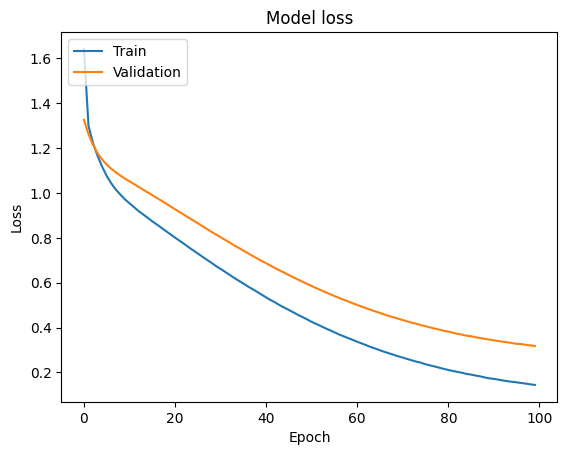

Saving model...
/home/mawf/brainvision/bv_training_stage_5/models/stage_5/V2/sub01/model_hidden_2_lr_0.0001_dropout_0.2_l2_0.0001.keras
Model saved.
Saving training history...
Training history saved.
Clearing the TensorFlow session...
Completed ROI:  V2 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub01
ROI_train shape:  (800, 261)
ROI_val shape:  (100, 261)
y_train shape:  (800, 261)
Y_val shape:  (100, 261)
Epoch 1/100
25/25 [==============================] - 2s 43ms/step - loss: 1.6391 - val_loss: 1.3168
Epoch 2/100
25/25 [==============================] - 1s 28ms/step - loss: 1.3005 - val_loss: 1.2523
Epoch 3/100
25/25 [==============================] - 1s 28ms/step - loss: 1.2242 - val_loss: 1.2038
Epoch 4/100
25/25 [==============================] - 1s 26ms/step - loss: 1.1699 - val_loss: 1.1664
Epoch 5/100
25/25 [==============================] - 1s 27ms/step - loss: 1.1238 - val_loss: 1.1370
Epoch 6/100
25/25 [

25/25 [==============================] - 1s 29ms/step - loss: 0.2182 - val_loss: 0.3718
Epoch 78/100
25/25 [==============================] - 1s 29ms/step - loss: 0.2138 - val_loss: 0.3663
Epoch 79/100
25/25 [==============================] - 1s 28ms/step - loss: 0.2089 - val_loss: 0.3624
Epoch 80/100
25/25 [==============================] - 1s 29ms/step - loss: 0.2044 - val_loss: 0.3574
Epoch 81/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1998 - val_loss: 0.3538
Epoch 82/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1956 - val_loss: 0.3497
Epoch 83/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1914 - val_loss: 0.3453
Epoch 84/100
25/25 [==============================] - 1s 30ms/step - loss: 0.1871 - val_loss: 0.3414
Epoch 85/100
25/25 [==============================] - 1s 28ms/step - loss: 0.1836 - val_loss: 0.3377
Epoch 86/100
25/25 [==============================] - 1s 26ms/step - loss: 0.1799 - val_loss: 0.3343
Epo

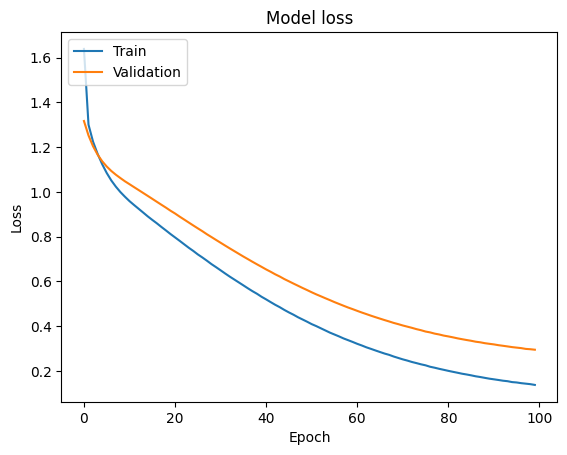

Saving model...
/home/mawf/brainvision/bv_training_stage_5/models/stage_5/V3/sub01/model_hidden_2_lr_0.0001_dropout_0.2_l2_0.0001.keras
Model saved.
Saving training history...
Training history saved.
Clearing the TensorFlow session...
Completed ROI:  V3 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub01
ROI_train shape:  (800, 107)
ROI_val shape:  (100, 107)
y_train shape:  (800, 107)
Y_val shape:  (100, 107)
Epoch 1/100
25/25 [==============================] - 1s 22ms/step - loss: 1.6817 - val_loss: 1.2878
Epoch 2/100
25/25 [==============================] - 0s 17ms/step - loss: 1.2817 - val_loss: 1.2243
Epoch 3/100
25/25 [==============================] - 1s 25ms/step - loss: 1.1726 - val_loss: 1.1788
Epoch 4/100
25/25 [==============================] - 0s 14ms/step - loss: 1.1059 - val_loss: 1.1451
Epoch 5/100
25/25 [==============================] - 1s 30ms/step - loss: 1.0546 - val_loss: 1.1199
Epoch 6/100
25/25 [

25/25 [==============================] - 1s 26ms/step - loss: 0.3307 - val_loss: 0.4902
Epoch 78/100
25/25 [==============================] - 1s 27ms/step - loss: 0.3242 - val_loss: 0.4835
Epoch 79/100
25/25 [==============================] - 1s 32ms/step - loss: 0.3176 - val_loss: 0.4771
Epoch 80/100
25/25 [==============================] - 1s 26ms/step - loss: 0.3122 - val_loss: 0.4716
Epoch 81/100
25/25 [==============================] - 1s 28ms/step - loss: 0.3044 - val_loss: 0.4649
Epoch 82/100
25/25 [==============================] - 1s 25ms/step - loss: 0.2982 - val_loss: 0.4596
Epoch 83/100
25/25 [==============================] - 1s 28ms/step - loss: 0.2926 - val_loss: 0.4534
Epoch 84/100
25/25 [==============================] - 1s 25ms/step - loss: 0.2876 - val_loss: 0.4480
Epoch 85/100
25/25 [==============================] - 1s 27ms/step - loss: 0.2812 - val_loss: 0.4426
Epoch 86/100
25/25 [==============================] - 1s 25ms/step - loss: 0.2763 - val_loss: 0.4374
Epo

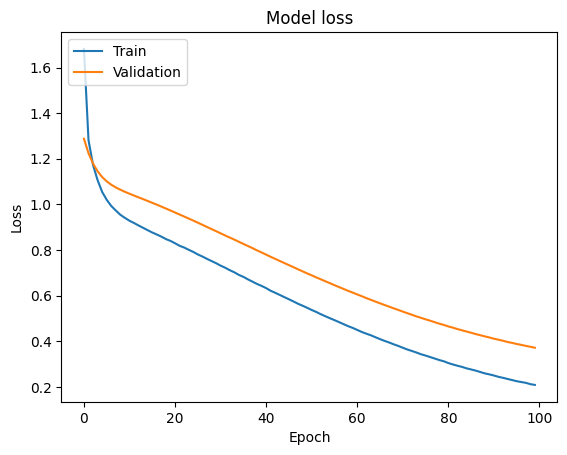

Saving model...
/home/mawf/brainvision/bv_training_stage_5/models/stage_5/V4/sub01/model_hidden_2_lr_0.0001_dropout_0.2_l2_0.0001.keras
Model saved.
Saving training history...
Training history saved.
Clearing the TensorFlow session...
Completed ROI:  V4 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub01
ROI_train shape:  (800, 1843)
ROI_val shape:  (100, 1843)
y_train shape:  (800, 1843)
Y_val shape:  (100, 1843)
Epoch 1/100
25/25 [==============================] - 2s 41ms/step - loss: 1.8323 - val_loss: 1.6623
Epoch 2/100
25/25 [==============================] - 1s 32ms/step - loss: 1.6265 - val_loss: 1.5670
Epoch 3/100
25/25 [==============================] - 1s 34ms/step - loss: 1.5339 - val_loss: 1.4816
Epoch 4/100
25/25 [==============================] - 1s 34ms/step - loss: 1.4508 - val_loss: 1.4047
Epoch 5/100
25/25 [==============================] - 1s 31ms/step - loss: 1.3730 - val_loss: 1.3334
Epoch 6/100
25

25/25 [==============================] - 0s 17ms/step - loss: 0.1308 - val_loss: 0.2843
Epoch 78/100
25/25 [==============================] - 0s 17ms/step - loss: 0.1298 - val_loss: 0.2839
Epoch 79/100
25/25 [==============================] - 0s 16ms/step - loss: 0.1296 - val_loss: 0.2834
Epoch 80/100
25/25 [==============================] - 0s 17ms/step - loss: 0.1294 - val_loss: 0.2832
Epoch 81/100
25/25 [==============================] - 0s 19ms/step - loss: 0.1291 - val_loss: 0.2821
Epoch 82/100
25/25 [==============================] - 2s 65ms/step - loss: 0.1283 - val_loss: 0.2830
Epoch 83/100
25/25 [==============================] - 2s 63ms/step - loss: 0.1280 - val_loss: 0.2819
Epoch 84/100
25/25 [==============================] - 1s 55ms/step - loss: 0.1275 - val_loss: 0.2823
Epoch 85/100
25/25 [==============================] - 1s 28ms/step - loss: 0.1273 - val_loss: 0.2819
Epoch 86/100
25/25 [==============================] - 0s 18ms/step - loss: 0.1271 - val_loss: 0.2804
Epo

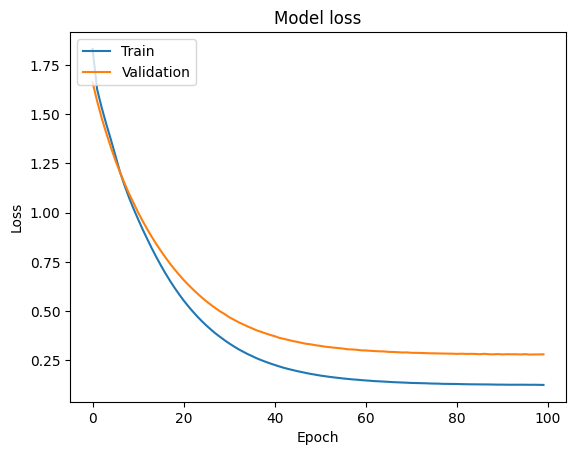

Saving model...
/home/mawf/brainvision/bv_training_stage_5/models/stage_5/LOC/sub01/model_hidden_2_lr_0.0001_dropout_0.2_l2_0.0001.keras
Model saved.
Saving training history...
Training history saved.
Clearing the TensorFlow session...
Completed ROI:  LOC sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub01
ROI_train shape:  (800, 351)
ROI_val shape:  (100, 351)
y_train shape:  (800, 351)
Y_val shape:  (100, 351)
Epoch 1/100
25/25 [==============================] - 2s 34ms/step - loss: 1.6648 - val_loss: 1.3657
Epoch 2/100
25/25 [==============================] - 1s 27ms/step - loss: 1.3481 - val_loss: 1.2999
Epoch 3/100
25/25 [==============================] - 1s 30ms/step - loss: 1.2731 - val_loss: 1.2490
Epoch 4/100
25/25 [==============================] - 1s 30ms/step - loss: 1.2157 - val_loss: 1.2084
Epoch 5/100
25/25 [==============================] - 1s 29ms/step - loss: 1.1634 - val_loss: 1.1745
Epoch 6/100
25/2

25/25 [==============================] - 0s 13ms/step - loss: 0.2043 - val_loss: 0.3683
Epoch 78/100
25/25 [==============================] - 0s 13ms/step - loss: 0.2003 - val_loss: 0.3636
Epoch 79/100
25/25 [==============================] - 0s 13ms/step - loss: 0.1957 - val_loss: 0.3594
Epoch 80/100
25/25 [==============================] - 0s 13ms/step - loss: 0.1917 - val_loss: 0.3555
Epoch 81/100
25/25 [==============================] - 0s 13ms/step - loss: 0.1877 - val_loss: 0.3516
Epoch 82/100
25/25 [==============================] - 0s 13ms/step - loss: 0.1843 - val_loss: 0.3491
Epoch 83/100
25/25 [==============================] - 0s 14ms/step - loss: 0.1808 - val_loss: 0.3443
Epoch 84/100
25/25 [==============================] - 0s 13ms/step - loss: 0.1769 - val_loss: 0.3415
Epoch 85/100
25/25 [==============================] - 0s 14ms/step - loss: 0.1734 - val_loss: 0.3382
Epoch 86/100
25/25 [==============================] - 0s 14ms/step - loss: 0.1706 - val_loss: 0.3355
Epo

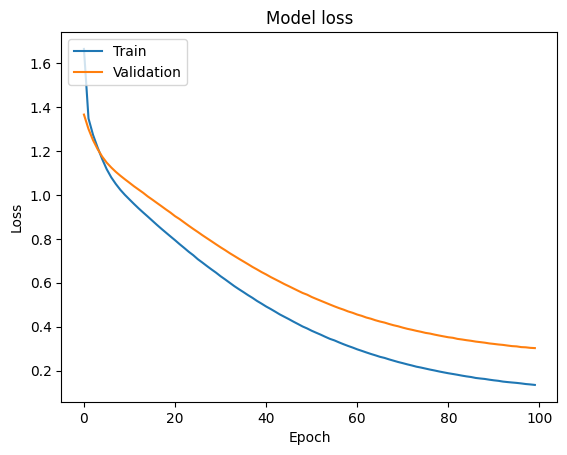

Saving model...
/home/mawf/brainvision/bv_training_stage_5/models/stage_5/EBA/sub01/model_hidden_2_lr_0.0001_dropout_0.2_l2_0.0001.keras
Model saved.
Saving training history...
Training history saved.
Clearing the TensorFlow session...
Completed ROI:  EBA sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub01
ROI_train shape:  (800, 68)
ROI_val shape:  (100, 68)
y_train shape:  (800, 68)
Y_val shape:  (100, 68)
Epoch 1/100
25/25 [==============================] - 4s 131ms/step - loss: 1.7215 - val_loss: 1.2769
Epoch 2/100
25/25 [==============================] - 1s 59ms/step - loss: 1.2852 - val_loss: 1.2124
Epoch 3/100
25/25 [==============================] - 1s 50ms/step - loss: 1.1510 - val_loss: 1.1668
Epoch 4/100
25/25 [==============================] - 0s 16ms/step - loss: 1.0808 - val_loss: 1.1336
Epoch 5/100
25/25 [==============================] - 0s 15ms/step - loss: 1.0332 - val_loss: 1.1096
Epoch 6/100
25/25 [

25/25 [==============================] - 0s 13ms/step - loss: 0.4001 - val_loss: 0.5591
Epoch 78/100
25/25 [==============================] - 0s 13ms/step - loss: 0.3928 - val_loss: 0.5534
Epoch 79/100
25/25 [==============================] - 0s 13ms/step - loss: 0.3869 - val_loss: 0.5454
Epoch 80/100
25/25 [==============================] - 0s 13ms/step - loss: 0.3806 - val_loss: 0.5399
Epoch 81/100
25/25 [==============================] - 0s 13ms/step - loss: 0.3732 - val_loss: 0.5329
Epoch 82/100
25/25 [==============================] - 0s 13ms/step - loss: 0.3664 - val_loss: 0.5266
Epoch 83/100
25/25 [==============================] - 0s 13ms/step - loss: 0.3608 - val_loss: 0.5203
Epoch 84/100
25/25 [==============================] - 0s 13ms/step - loss: 0.3540 - val_loss: 0.5143
Epoch 85/100
25/25 [==============================] - 0s 13ms/step - loss: 0.3489 - val_loss: 0.5079
Epoch 86/100
25/25 [==============================] - 0s 13ms/step - loss: 0.3422 - val_loss: 0.5021
Epo

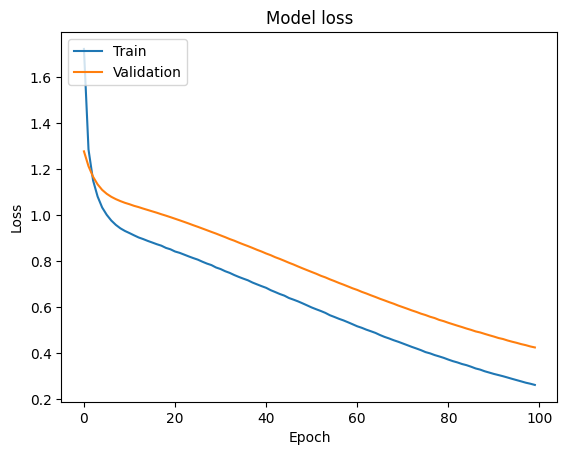

Saving model...
/home/mawf/brainvision/bv_training_stage_5/models/stage_5/FFA/sub01/model_hidden_2_lr_0.0001_dropout_0.2_l2_0.0001.keras
Model saved.
Saving training history...
Training history saved.
Clearing the TensorFlow session...
Completed ROI:  FFA sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub01
ROI_train shape:  (800, 341)
ROI_val shape:  (100, 341)
y_train shape:  (800, 341)
Y_val shape:  (100, 341)
Epoch 1/100
25/25 [==============================] - 1s 19ms/step - loss: 1.6247 - val_loss: 1.3513
Epoch 2/100
25/25 [==============================] - 0s 13ms/step - loss: 1.3114 - val_loss: 1.2854
Epoch 3/100
25/25 [==============================] - 0s 13ms/step - loss: 1.2390 - val_loss: 1.2349
Epoch 4/100
25/25 [==============================] - 0s 14ms/step - loss: 1.1857 - val_loss: 1.1954
Epoch 5/100
25/25 [==============================] - 0s 14ms/step - loss: 1.1404 - val_loss: 1.1630
Epoch 6/100
25/2

25/25 [==============================] - 1s 30ms/step - loss: 0.1880 - val_loss: 0.3587
Epoch 78/100
25/25 [==============================] - 1s 26ms/step - loss: 0.1842 - val_loss: 0.3551
Epoch 79/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1796 - val_loss: 0.3511
Epoch 80/100
25/25 [==============================] - 1s 29ms/step - loss: 0.1760 - val_loss: 0.3473
Epoch 81/100
25/25 [==============================] - 1s 29ms/step - loss: 0.1722 - val_loss: 0.3440
Epoch 82/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1690 - val_loss: 0.3396
Epoch 83/100
25/25 [==============================] - 1s 28ms/step - loss: 0.1653 - val_loss: 0.3364
Epoch 84/100
25/25 [==============================] - 1s 26ms/step - loss: 0.1618 - val_loss: 0.3345
Epoch 85/100
25/25 [==============================] - 1s 30ms/step - loss: 0.1585 - val_loss: 0.3302
Epoch 86/100
25/25 [==============================] - 1s 29ms/step - loss: 0.1560 - val_loss: 0.3279
Epo

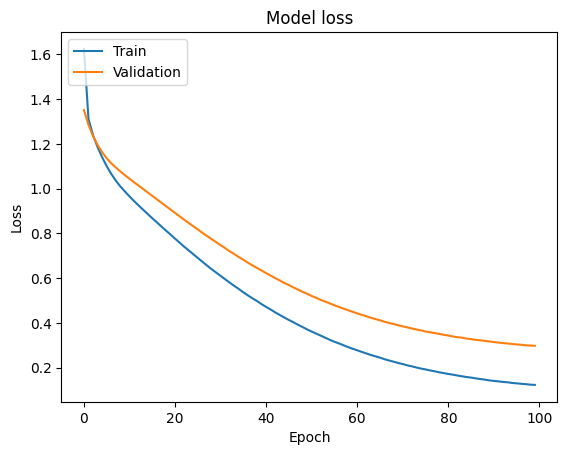

Saving model...
/home/mawf/brainvision/bv_training_stage_5/models/stage_5/STS/sub01/model_hidden_2_lr_0.0001_dropout_0.2_l2_0.0001.keras
Model saved.
Saving training history...
Training history saved.
Clearing the TensorFlow session...
Completed ROI:  STS sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub01
ROI_train shape:  (800, 425)
ROI_val shape:  (100, 425)
y_train shape:  (800, 425)
Y_val shape:  (100, 425)
Epoch 1/100
25/25 [==============================] - 2s 43ms/step - loss: 1.6082 - val_loss: 1.3444
Epoch 2/100
25/25 [==============================] - 1s 27ms/step - loss: 1.3221 - val_loss: 1.2773
Epoch 3/100
25/25 [==============================] - 1s 25ms/step - loss: 1.2522 - val_loss: 1.2250
Epoch 4/100
25/25 [==============================] - 1s 27ms/step - loss: 1.1983 - val_loss: 1.1832
Epoch 5/100
25/25 [==============================] - 1s 26ms/step - loss: 1.1515 - val_loss: 1.1485
Epoch 6/100
25/2

25/25 [==============================] - 1s 25ms/step - loss: 0.1625 - val_loss: 0.3069
Epoch 78/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1587 - val_loss: 0.3025
Epoch 79/100
25/25 [==============================] - 1s 28ms/step - loss: 0.1557 - val_loss: 0.3004
Epoch 80/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1528 - val_loss: 0.2969
Epoch 81/100
25/25 [==============================] - 0s 19ms/step - loss: 0.1499 - val_loss: 0.2943
Epoch 82/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1466 - val_loss: 0.2914
Epoch 83/100
25/25 [==============================] - 1s 20ms/step - loss: 0.1439 - val_loss: 0.2890
Epoch 84/100
25/25 [==============================] - 1s 26ms/step - loss: 0.1419 - val_loss: 0.2865
Epoch 85/100
25/25 [==============================] - 1s 28ms/step - loss: 0.1391 - val_loss: 0.2841
Epoch 86/100
25/25 [==============================] - 0s 18ms/step - loss: 0.1367 - val_loss: 0.2817
Epo

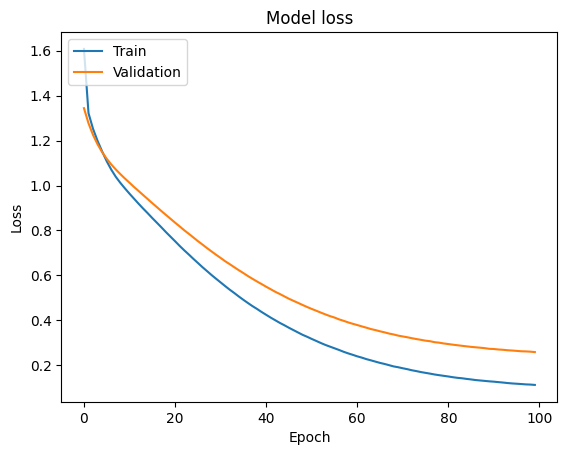

Saving model...
/home/mawf/brainvision/bv_training_stage_5/models/stage_5/PPA/sub01/model_hidden_2_lr_0.0001_dropout_0.2_l2_0.0001.keras
Model saved.
Saving training history...
Training history saved.
Clearing the TensorFlow session...
Completed ROI:  PPA sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub02
ROI_train shape:  (800, 285)
ROI_val shape:  (100, 285)
y_train shape:  (800, 285)
Y_val shape:  (100, 285)
Epoch 1/100


2024-01-17 21:00:20.710113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 16.00GiB (17179869184 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-17 21:00:20.715622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 16.00GiB (17179869184 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-17 21:00:30.718431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 16.00GiB (17179869184 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-17 21:00:30.720922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 16.00GiB (17179869184 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-17 21:00:30.722753: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 198.35MiB (rounded to 207986176)requested by op gradient_tape/sequential/dense/M

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential/dense/MatMul/MatMul' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_25616/3892086243.py", line 10, in <module>
      run_training_pipeline(hpo=False)
    File "/tmp/ipykernel_25616/1187923981.py", line 64, in run_training_pipeline
      train_model(layer=layer,
    File "/tmp/ipykernel_25616/969079899.py", line 74, in train_model
      history = model.fit(X_train, y_train,
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/optimizer_v2.py", line 585, in minimize
      grads_and_vars = self._compute_gradients(
    File "/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/optimizer_v2.py", line 643, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/optimizer_v2.py", line 519, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential/dense/MatMul/MatMul'
OOM when allocating tensor with shape[8761,5935] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential/dense/MatMul/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1148550]

In [16]:
# conduct training & evaluation
# if evaluation should be started before all models are trained (with all models that have been trained so far), this can be done via simply calling "run evaluation pipeline" separately (via evaluation.ipynb)
print("GPU available:", tf.config.list_physical_devices('GPU'))
if tf.test.is_gpu_available(): 
#     # set gpu computing distribution strategy
#     strategy = tf.distribute.MirroredStrategy()
#     # Print the number of devices available
#     print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    
    run_training_pipeline(hpo=False)
#     run_evaluation_pipeline(data_mode="val")

else:
    run_training_pipeline(hpo=True)
    run_evaluation_pipeline(data_mode="val")

GPU available: []
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Data are already downloaded.
base_train shape:  (800, 5625)
base_val shape:  (100, 5625)
motion_train shape:  (800, 3136)
motion_val shape:  (100, 3136)
Starting ROI:  WB sub:  sub01


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


ROI_train shape:  (800, 18222)
ROI_val shape:  (100, 18222)
y_train shape:  (800, 18222)
Y_val shape:  (100, 18222)
Epoch 1/100
25/25 [==============================] - 58s 2s/step - loss: 34.0309 - val_loss: 26.8856
Epoch 2/100
25/25 [==============================] - 57s 2s/step - loss: 21.1639 - val_loss: 15.7642
Epoch 3/100
25/25 [==============================] - 58s 2s/step - loss: 12.1678 - val_loss: 8.8933
Epoch 4/100
25/25 [==============================] - 58s 2s/step - loss: 6.7957 - val_loss: 4.9135
Epoch 5/100
25/25 [==============================] - 58s 2s/step - loss: 3.7330 - val_loss: 2.6872
Epoch 6/100
25/25 [==============================] - 58s 2s/step - loss: 2.0425 - val_loss: 1.4802
Epoch 7/100
25/25 [==============================] - 58s 2s/step - loss: 1.1377 - val_loss: 0.8473
Epoch 8/100
25/25 [==============================] - 57s 2s/step - loss: 0.6686 - val_loss: 0.5279
Epoch 9/100
25/25 [==============================] - 57s 2s/step - loss: 0.4322 - val_l

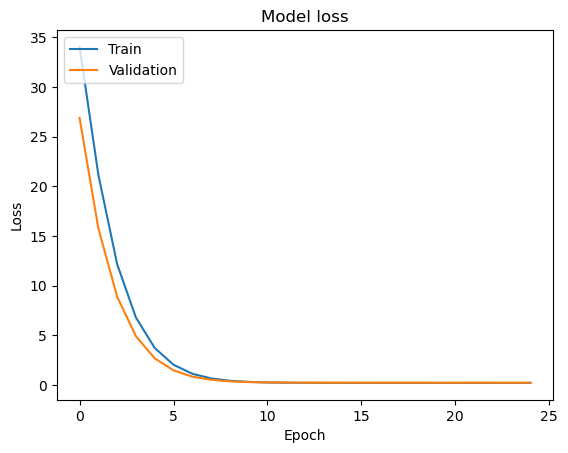

/work/brainvision_modelling3/models/stage_5/WB/sub01
Completed ROI:  WB sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub01
ROI_train shape:  (800, 232)
ROI_val shape:  (100, 232)
y_train shape:  (800, 232)
Y_val shape:  (100, 232)
Epoch 1/100
25/25 [==============================] - 8s 286ms/step - loss: 11.6386 - val_loss: 10.8198
Epoch 2/100
25/25 [==============================] - 7s 281ms/step - loss: 10.3045 - val_loss: 9.7574
Epoch 3/100
25/25 [==============================] - 7s 284ms/step - loss: 9.2614 - val_loss: 8.7854
Epoch 4/100
25/25 [==============================] - 7s 278ms/step - loss: 8.3243 - val_loss: 7.9147
Epoch 5/100
25/25 [==============================] - 7s 278ms/step - loss: 7.4828 - val_loss: 7.1357
Epoch 6/100
25/25 [==============================] - 7s 278ms/step - loss: 6.7241 - val_loss: 6.4360
Epoch 7/100
25/25 [==============================] - 7s 279ms/step - loss: 6.0401 - val_loss

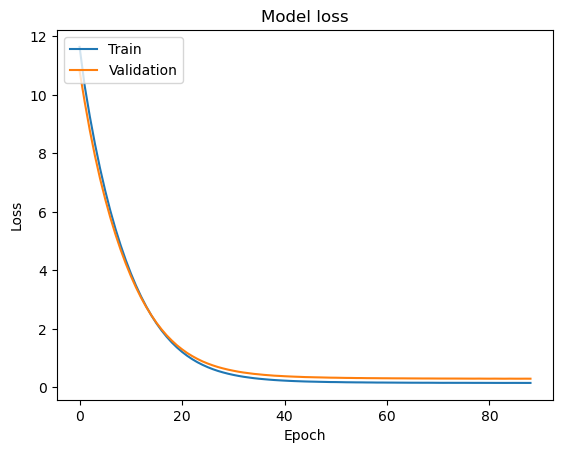

/work/brainvision_modelling3/models/stage_5/V1/sub01
Completed ROI:  V1 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub01
ROI_train shape:  (800, 231)
ROI_val shape:  (100, 231)
y_train shape:  (800, 231)
Y_val shape:  (100, 231)
Epoch 1/100
25/25 [==============================] - 8s 284ms/step - loss: 11.6392 - val_loss: 10.8183
Epoch 2/100
25/25 [==============================] - 7s 279ms/step - loss: 10.3084 - val_loss: 9.7584
Epoch 3/100
25/25 [==============================] - 7s 276ms/step - loss: 9.2669 - val_loss: 8.7877
Epoch 4/100
25/25 [==============================] - 7s 279ms/step - loss: 8.3317 - val_loss: 7.9180
Epoch 5/100
25/25 [==============================] - 7s 286ms/step - loss: 7.4910 - val_loss: 7.1391
Epoch 6/100
23/25 [==========================>...] - ETA: 0s - loss: 6.7632

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



25/25 [==============================] - 11s 447ms/step - loss: 0.1881 - val_loss: 0.2558
Epoch 48/100
25/25 [==============================] - 11s 438ms/step - loss: 0.1863 - val_loss: 0.2536
Epoch 49/100
25/25 [==============================] - 11s 438ms/step - loss: 0.1849 - val_loss: 0.2514
Epoch 50/100
25/25 [==============================] - 11s 443ms/step - loss: 0.1833 - val_loss: 0.2511
Epoch 51/100
25/25 [==============================] - 11s 438ms/step - loss: 0.1826 - val_loss: 0.2483
Epoch 52/100
25/25 [==============================] - 11s 441ms/step - loss: 0.1814 - val_loss: 0.2478
Epoch 53/100
25/25 [==============================] - 11s 440ms/step - loss: 0.1803 - val_loss: 0.2463
Epoch 54/100
25/25 [==============================] - 11s 441ms/step - loss: 0.1795 - val_loss: 0.2454
Epoch 55/100
25/25 [==============================] - 11s 443ms/step - loss: 0.1791 - val_loss: 0.2442
Epoch 56/100
25/25 [==============================] - 11s 442ms/step - loss: 0.1781 - 

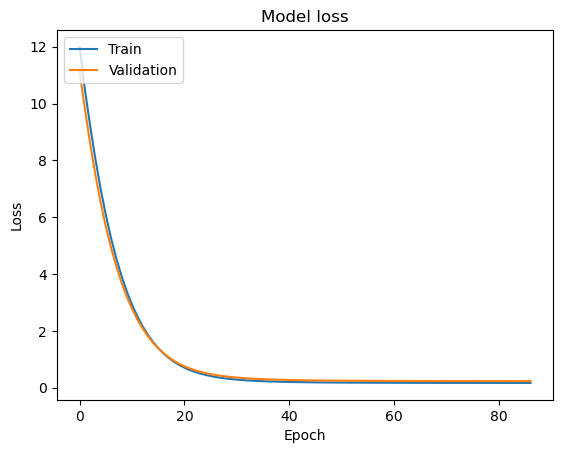

/work/brainvision_modelling3/models/stage_5/PPA/sub01
Completed ROI:  PPA sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub02
ROI_train shape:  (800, 21573)
ROI_val shape:  (100, 21573)
y_train shape:  (800, 21573)
Y_val shape:  (100, 21573)
Epoch 1/100
25/25 [==============================] - 103s 4s/step - loss: 37.4253 - val_loss: 28.9701
Epoch 2/100
25/25 [==============================] - 99s 4s/step - loss: 22.3811 - val_loss: 16.2595
Epoch 3/100
25/25 [==============================] - 99s 4s/step - loss: 12.3021 - val_loss: 8.7593
Epoch 4/100
25/25 [==============================] - 98s 4s/step - loss: 6.5601 - val_loss: 4.6222
Epoch 5/100
25/25 [==============================] - 96s 4s/step - loss: 3.4448 - val_loss: 2.4220
Epoch 6/100
25/25 [==============================] - 96s 4s/step - loss: 1.8109 - val_loss: 1.2898
Epoch 7/100
25/25 [==============================] - 95s 4s/step - loss: 0.9815 - val_loss:

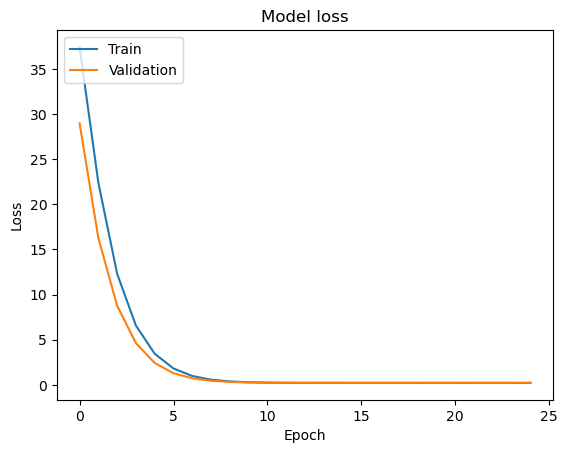

/work/brainvision_modelling3/models/stage_5/WB/sub02
Completed ROI:  WB sub:  sub02
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub02
ROI_train shape:  (800, 285)
ROI_val shape:  (100, 285)
y_train shape:  (800, 285)
Y_val shape:  (100, 285)
Epoch 1/100
25/25 [==============================] - 8s 282ms/step - loss: 11.7470 - val_loss: 10.9135
Epoch 2/100
25/25 [==============================] - 7s 286ms/step - loss: 10.3778 - val_loss: 9.7870
Epoch 3/100
25/25 [==============================] - 7s 275ms/step - loss: 9.2711 - val_loss: 8.7446
Epoch 4/100
25/25 [==============================] - 7s 275ms/step - loss: 8.2687 - val_loss: 7.8071
Epoch 5/100
25/25 [==============================] - 7s 276ms/step - loss: 7.3665 - val_loss: 6.9679
Epoch 6/100
25/25 [==============================] - 7s 278ms/step - loss: 6.5558 - val_loss: 6.2172
Epoch 7/100
25/25 [==============================] - 7s 275ms/step - loss: 5.8280 - val_loss

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



25/25 [==============================] - 10s 383ms/step - loss: 5.0291 - val_loss: 4.9519
Epoch 12/100
25/25 [==============================] - 10s 386ms/step - loss: 4.6507 - val_loss: 4.5885
Epoch 13/100
25/25 [==============================] - 10s 381ms/step - loss: 4.2937 - val_loss: 4.2456
Epoch 14/100
25/25 [==============================] - 9s 380ms/step - loss: 3.9571 - val_loss: 3.9222
Epoch 15/100
25/25 [==============================] - 9s 377ms/step - loss: 3.6411 - val_loss: 3.6188
Epoch 16/100
25/25 [==============================] - 9s 379ms/step - loss: 3.3437 - val_loss: 3.3344
Epoch 17/100
25/25 [==============================] - 9s 378ms/step - loss: 3.0674 - val_loss: 3.0689
Epoch 18/100
25/25 [==============================] - 82s 3s/step - loss: 0.6230 - val_loss: 0.4930
Epoch 9/100
25/25 [==============================] - 81s 3s/step - loss: 0.4038 - val_loss: 0.3549
Epoch 10/100
25/25 [==============================] - 82s 3s/step - loss: 0.2984 - val_loss: 0.28

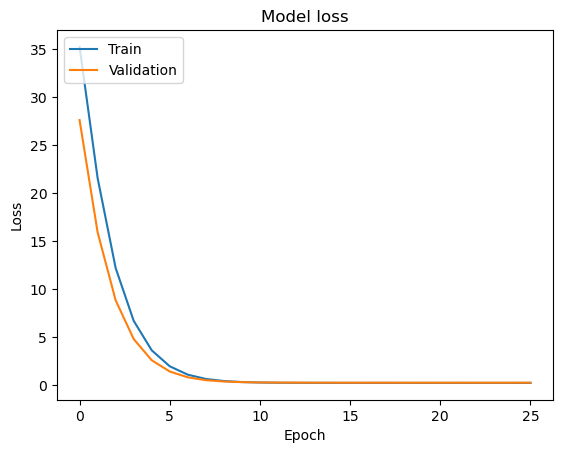

/work/brainvision_modelling3/models/stage_5/WB/sub04
Completed ROI:  WB sub:  sub04
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub04
ROI_train shape:  (800, 176)
ROI_val shape:  (100, 176)
y_train shape:  (800, 176)
Y_val shape:  (100, 176)
Epoch 1/100
25/25 [==============================] - 8s 280ms/step - loss: 11.5545 - val_loss: 10.7181
Epoch 2/100
25/25 [==============================] - 7s 275ms/step - loss: 10.2579 - val_loss: 9.7382
Epoch 3/100
25/25 [==============================] - 7s 274ms/step - loss: 9.2918 - val_loss: 8.8596
Epoch 4/100
25/25 [==============================] - 7s 279ms/step - loss: 8.4414 - val_loss: 8.0804
Epoch 5/100
25/25 [==============================] - 7s 275ms/step - loss: 7.6824 - val_loss: 7.3838
Epoch 6/100
25/25 [==============================] - 7s 279ms/step - loss: 7.0029 - val_loss: 6.7546
Epoch 7/100
25/25 [==============================] - 7s 273ms/step - loss: 6.3872 - val_loss

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Total params: 69022094 (263.30 MB)
Trainable params: 69022094 (263.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


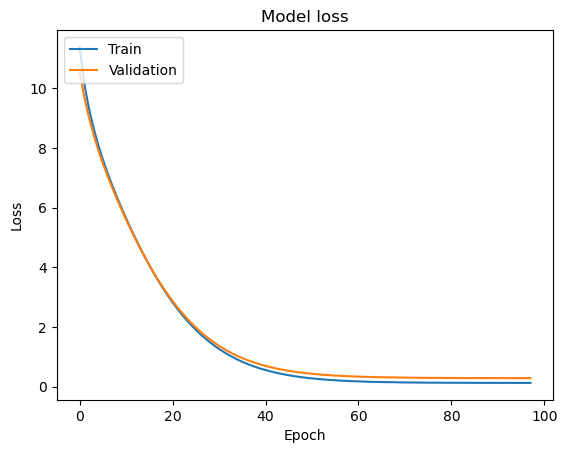

/work/brainvision_modelling3/models/stage_5/V4/sub05
Completed ROI:  V4 sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub05
ROI_train shape:  (800, 1397)
ROI_val shape:  (100, 1397)
y_train shape:  (800, 1397)
Y_val shape:  (100, 1397)
Epoch 1/100
25/25 [==============================] - 13s 463ms/step - loss: 13.8169 - val_loss: 12.7202
Epoch 2/100
25/25 [==============================] - 11s 456ms/step - loss: 11.6615 - val_loss: 10.5684
Epoch 3/100
25/25 [==============================] - 11s 457ms/step - loss: 9.5727 - val_loss: 8.5967
Epoch 4/100
25/25 [==============================] - 11s 458ms/step - loss: 7.7385 - val_loss: 6.9200
Epoch 5/100
25/25 [==============================] - 11s 458ms/step - loss: 6.2001 - val_loss: 5.5357
Epoch 6/100
25/25 [==============================] - 11s 459ms/step - loss: 4.9362 - val_loss: 4.4145
Epoch 7/100
25/25 [==============================] - 11s 459ms/step - loss: 3.90

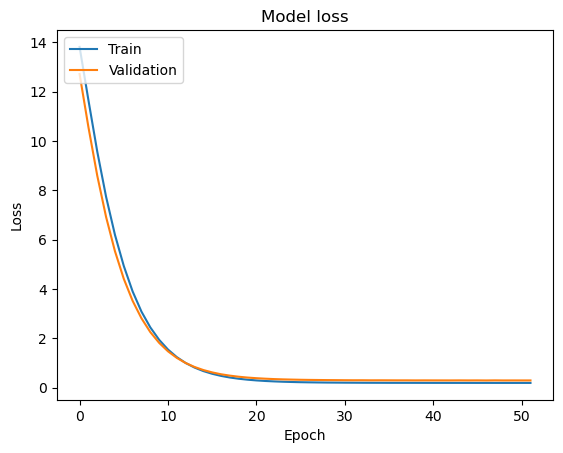

/work/brainvision_modelling3/models/stage_5/LOC/sub05
Completed ROI:  LOC sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub05
ROI_train shape:  (800, 309)
ROI_val shape:  (100, 309)
y_train shape:  (800, 309)
Y_val shape:  (100, 309)
Epoch 1/100
25/25 [==============================] - 11s 418ms/step - loss: 11.8295 - val_loss: 11.0315
Epoch 2/100
25/25 [==============================] - 11s 422ms/step - loss: 10.4493 - val_loss: 9.8966
Epoch 3/100
25/25 [==============================] - 10s 418ms/step - loss: 9.3305 - val_loss: 8.8441
Epoch 4/100
25/25 [==============================] - 10s 420ms/step - loss: 8.3147 - val_loss: 7.8962
Epoch 5/100
25/25 [==============================] - 10s 419ms/step - loss: 7.3985 - val_loss: 7.0482
Epoch 6/100
25/25 [==============================] - 10s 416ms/step - loss: 6.5780 - val_loss: 6.2909
Epoch 7/100
25/25 [==============================] - 10s 420ms/step - loss: 5.8465 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



25/25 [==============================] - 10s 396ms/step - loss: 1.9120 - val_loss: 1.9715
Epoch 27/100
25/25 [==============================] - 10s 395ms/step - loss: 1.7628 - val_loss: 1.8290
Epoch 28/100
25/25 [==============================] - 10s 393ms/step - loss: 1.6257 - val_loss: 1.6961
Epoch 29/100
25/25 [==============================] - 10s 394ms/step - loss: 1.4969 - val_loss: 1.5729
Epoch 30/100
25/25 [==============================] - 10s 390ms/step - loss: 1.3793 - val_loss: 1.4595
Epoch 31/100
25/25 [==============================] - 10s 394ms/step - loss: 1.2694 - val_loss: 1.3545
Epoch 32/100
25/25 [==============================] - 10s 395ms/step - loss: 1.1687 - val_loss: 1.2586
Epoch 33/100
25/25 [==============================] - 10s 396ms/step - loss: 1.0759 - val_loss: 1.1691
Epoch 34/100
25/25 [==============================] - 10s 398ms/step - loss: 0.9898 - val_loss: 1.0878
Epoch 35/100
25/25 [==============================] - 10s 393ms/step - loss: 0.9099 - 

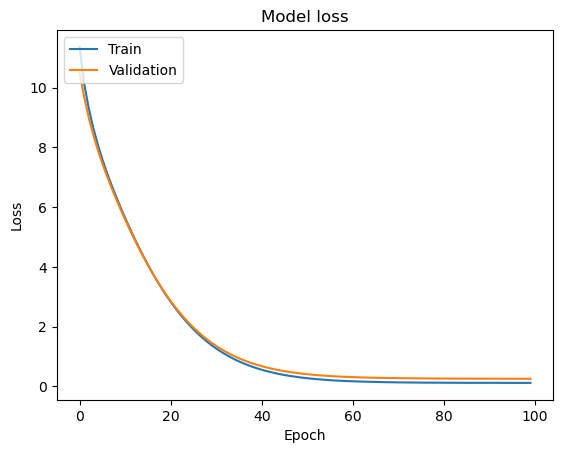

/work/brainvision_modelling3/models/stage_5/FFA/sub05
Completed ROI:  FFA sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub05
ROI_train shape:  (800, 219)
ROI_val shape:  (100, 219)
y_train shape:  (800, 219)
Y_val shape:  (100, 219)
Epoch 1/100
25/25 [==============================] - 11s 423ms/step - loss: 11.6173 - val_loss: 10.7832
Epoch 2/100
25/25 [==============================] - 10s 408ms/step - loss: 10.2904 - val_loss: 9.7448
Epoch 3/100
25/25 [==============================] - 10s 413ms/step - loss: 9.2683 - val_loss: 8.7967
Epoch 4/100
25/25 [==============================] - 10s 407ms/step - loss: 8.3544 - val_loss: 7.9477
Epoch 5/100
25/25 [==============================] - 10s 404ms/step - loss: 7.5341 - val_loss: 7.1865
Epoch 6/100
25/25 [==============================] - 10s 404ms/step - loss: 6.7962 - val_loss: 6.5013
Epoch 7/100
25/25 [==============================] - 10s 404ms/step - loss: 6.1303 

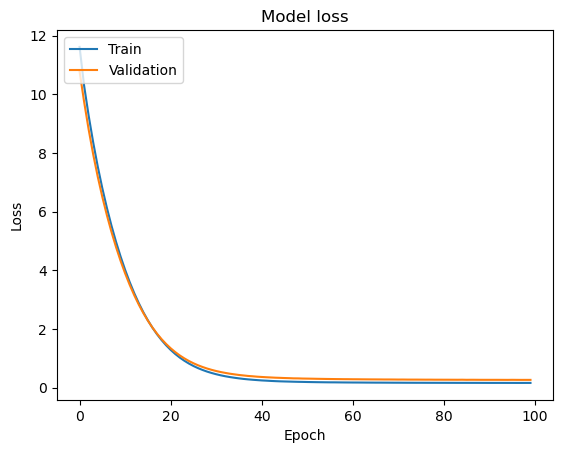

/work/brainvision_modelling3/models/stage_5/STS/sub05
Completed ROI:  STS sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub05
ROI_train shape:  (800, 210)
ROI_val shape:  (100, 210)
y_train shape:  (800, 210)
Y_val shape:  (100, 210)
Epoch 1/100
25/25 [==============================] - 11s 419ms/step - loss: 11.5766 - val_loss: 10.7438
Epoch 2/100
25/25 [==============================] - 10s 416ms/step - loss: 10.2552 - val_loss: 9.7084
Epoch 3/100
25/25 [==============================] - 10s 416ms/step - loss: 9.2376 - val_loss: 8.7637
Epoch 4/100
25/25 [==============================] - 10s 420ms/step - loss: 8.3284 - val_loss: 7.9173
Epoch 5/100
25/25 [==============================] - 10s 416ms/step - loss: 7.5113 - val_loss: 7.1569
Epoch 6/100
25/25 [==============================] - 10s 413ms/step - loss: 6.7743 - val_loss: 6.4710
Epoch 7/100
25/25 [==============================] - 10s 412ms/step - loss: 6.1088 

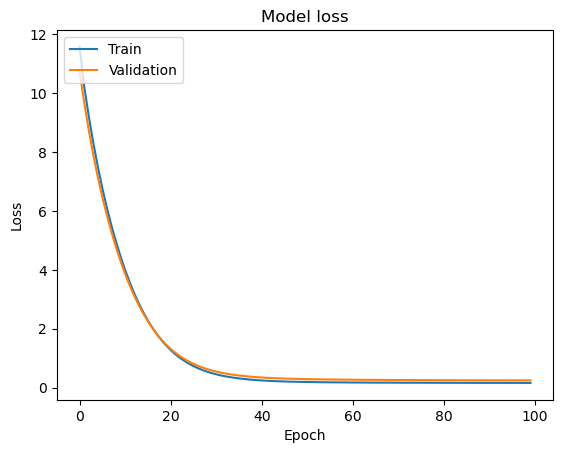

/work/brainvision_modelling3/models/stage_5/PPA/sub05
Completed ROI:  PPA sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub06
ROI_train shape:  (800, 19818)
ROI_val shape:  (100, 19818)
y_train shape:  (800, 19818)
Y_val shape:  (100, 19818)
Epoch 1/100
25/25 [==============================] - 84s 3s/step - loss: 35.6530 - val_loss: 27.8797
Epoch 2/100
25/25 [==============================] - 82s 3s/step - loss: 21.7503 - val_loss: 15.9985
Epoch 3/100
25/25 [==============================] - 82s 3s/step - loss: 12.2337 - val_loss: 8.8222
Epoch 4/100
25/25 [==============================] - 82s 3s/step - loss: 6.6801 - val_loss: 4.7628
Epoch 5/100
25/25 [==============================] - 82s 3s/step - loss: 3.5892 - val_loss: 2.5472
Epoch 6/100
25/25 [==============================] - 82s 3s/step - loss: 1.9248 - val_loss: 1.3759
Epoch 7/100
25/25 [==============================] - 82s 3s/step - loss: 1.0570 - val_loss: 

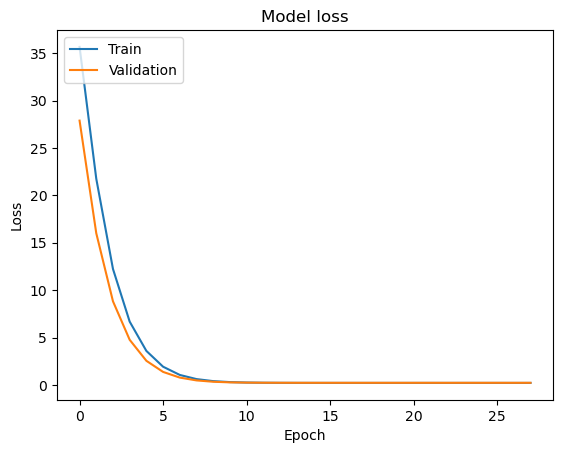

/work/brainvision_modelling3/models/stage_5/WB/sub06
Completed ROI:  WB sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub06
ROI_train shape:  (800, 286)
ROI_val shape:  (100, 286)
y_train shape:  (800, 286)
Y_val shape:  (100, 286)
Epoch 1/100
25/25 [==============================] - 9s 279ms/step - loss: 11.7504 - val_loss: 10.9095
Epoch 2/100
25/25 [==============================] - 7s 276ms/step - loss: 10.3812 - val_loss: 9.7831
Epoch 3/100
25/25 [==============================] - 7s 277ms/step - loss: 9.2739 - val_loss: 8.7411
Epoch 4/100
25/25 [==============================] - 7s 279ms/step - loss: 8.2715 - val_loss: 7.8041
Epoch 5/100
25/25 [==============================] - 7s 273ms/step - loss: 7.3691 - val_loss: 6.9660
Epoch 6/100
25/25 [==============================] - 7s 272ms/step - loss: 6.5586 - val_loss: 6.2167
Epoch 7/100
25/25 [==============================] - 7s 274ms/step - loss: 5.8336 - val_loss

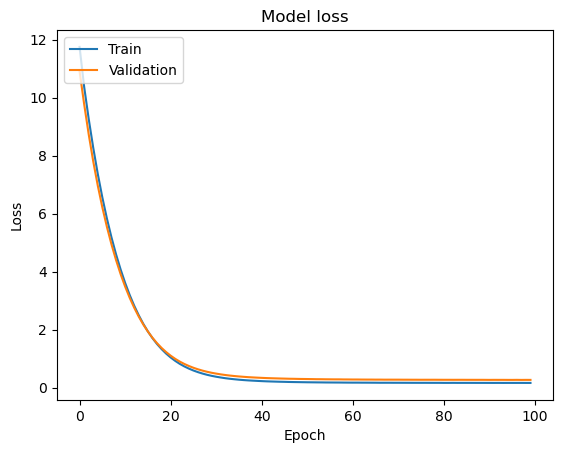

/work/brainvision_modelling3/models/stage_5/V1/sub06
Completed ROI:  V1 sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub06
ROI_train shape:  (800, 281)
ROI_val shape:  (100, 281)
y_train shape:  (800, 281)
Y_val shape:  (100, 281)
Epoch 1/100
25/25 [==============================] - 10s 370ms/step - loss: 11.7425 - val_loss: 10.9039
Epoch 2/100
25/25 [==============================] - 9s 363ms/step - loss: 10.3798 - val_loss: 9.7835
Epoch 3/100
25/25 [==============================] - 9s 362ms/step - loss: 9.2782 - val_loss: 8.7476
Epoch 4/100
25/25 [==============================] - 9s 367ms/step - loss: 8.2817 - val_loss: 7.8167
Epoch 5/100
25/25 [==============================] - 9s 364ms/step - loss: 7.3850 - val_loss: 6.9839
Epoch 6/100
25/25 [==============================] - 9s 366ms/step - loss: 6.5797 - val_loss: 6.2392
Epoch 7/100
25/25 [==============================] - 9s 363ms/step - loss: 5.8585 - val_los

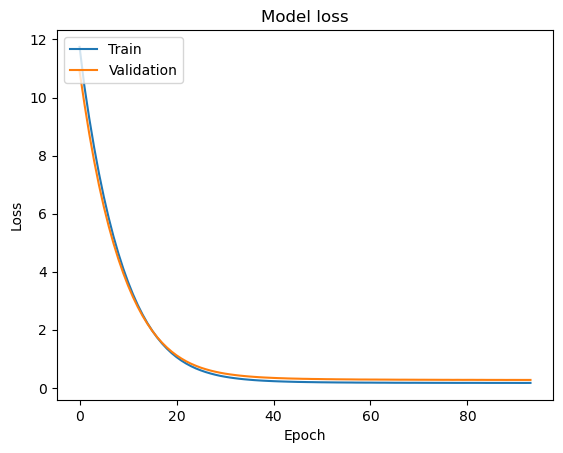

/work/brainvision_modelling3/models/stage_5/V2/sub06
Completed ROI:  V2 sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub06
ROI_train shape:  (800, 229)
ROI_val shape:  (100, 229)
y_train shape:  (800, 229)
Y_val shape:  (100, 229)
Epoch 1/100
25/25 [==============================] - 11s 430ms/step - loss: 11.6457 - val_loss: 10.8143
Epoch 2/100
25/25 [==============================] - 10s 415ms/step - loss: 10.3161 - val_loss: 9.7633
Epoch 3/100
25/25 [==============================] - 10s 415ms/step - loss: 9.2835 - val_loss: 8.8037
Epoch 4/100
25/25 [==============================] - 10s 420ms/step - loss: 8.3588 - val_loss: 7.9444
Epoch 5/100
25/25 [==============================] - 10s 413ms/step - loss: 7.5292 - val_loss: 7.1750
Epoch 6/100
25/25 [==============================] - 11s 421ms/step - loss: 6.7815 - val_loss: 6.4826
Epoch 7/100
25/25 [==============================] - 11s 422ms/step - loss: 6.1081 - v

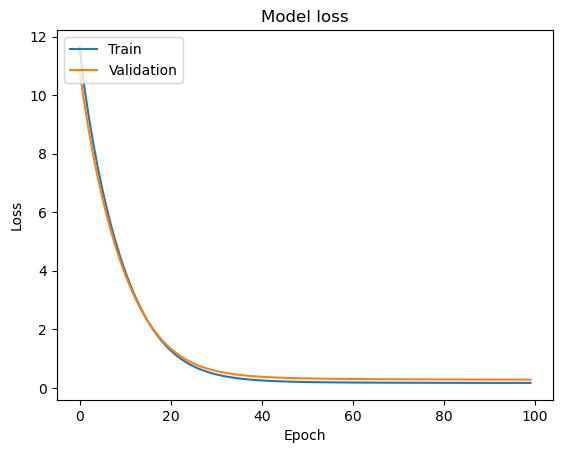

/work/brainvision_modelling3/models/stage_5/V3/sub06
Completed ROI:  V3 sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub06
ROI_train shape:  (800, 108)
ROI_val shape:  (100, 108)
y_train shape:  (800, 108)
Y_val shape:  (100, 108)
Epoch 1/100
25/25 [==============================] - 11s 412ms/step - loss: 11.4216 - val_loss: 10.5805
Epoch 2/100
25/25 [==============================] - 10s 410ms/step - loss: 10.1722 - val_loss: 9.7009
Epoch 3/100
25/25 [==============================] - 10s 408ms/step - loss: 9.2973 - val_loss: 8.9374
Epoch 4/100
25/25 [==============================] - 10s 410ms/step - loss: 8.5596 - val_loss: 8.2730
Epoch 5/100
25/25 [==============================] - 10s 414ms/step - loss: 7.9136 - val_loss: 7.6836
Epoch 6/100
25/25 [==============================] - 10s 414ms/step - loss: 7.3382 - val_loss: 7.1514
Epoch 7/100
25/25 [==============================] - 10s 415ms/step - loss: 6.8159 - v

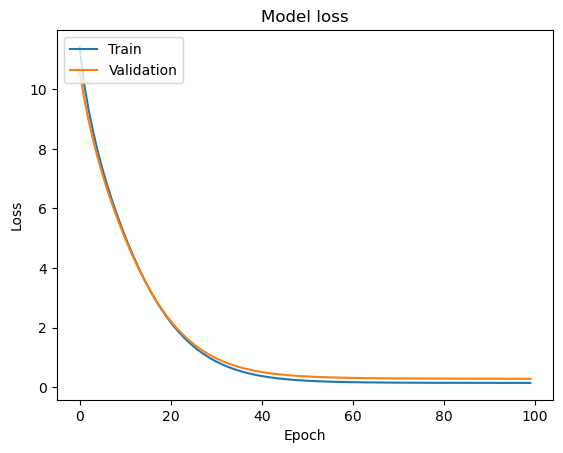

/work/brainvision_modelling3/models/stage_5/V4/sub06
Completed ROI:  V4 sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub06
ROI_train shape:  (800, 1356)
ROI_val shape:  (100, 1356)
y_train shape:  (800, 1356)
Y_val shape:  (100, 1356)
Epoch 1/100
25/25 [==============================] - 13s 482ms/step - loss: 13.7374 - val_loss: 12.6291
Epoch 2/100
25/25 [==============================] - 12s 476ms/step - loss: 11.6086 - val_loss: 10.5045
Epoch 3/100
25/25 [==============================] - 12s 479ms/step - loss: 9.5443 - val_loss: 8.5537
Epoch 4/100
25/25 [==============================] - 12s 474ms/step - loss: 7.7274 - val_loss: 6.8906
Epoch 5/100
25/25 [==============================] - 12s 473ms/step - loss: 6.1999 - val_loss: 5.5141
Epoch 6/100
25/25 [==============================] - 12s 473ms/step - loss: 4.9406 - val_loss: 4.3956
Epoch 7/100
25/25 [==============================] - 12s 477ms/step - loss: 3.91

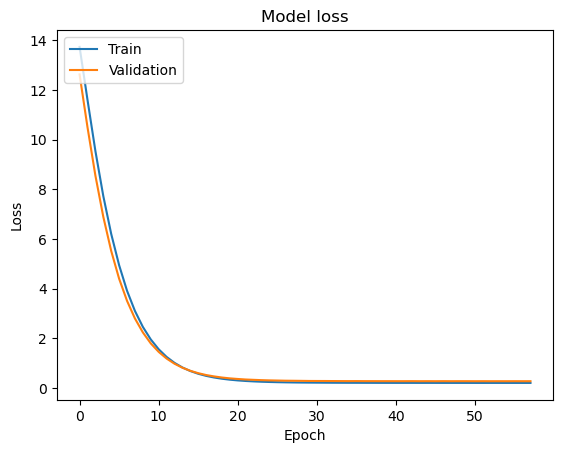

/work/brainvision_modelling3/models/stage_5/LOC/sub06
Completed ROI:  LOC sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub06
ROI_train shape:  (800, 308)
ROI_val shape:  (100, 308)
y_train shape:  (800, 308)
Y_val shape:  (100, 308)
Epoch 1/100
25/25 [==============================] - 11s 420ms/step - loss: 11.7885 - val_loss: 10.9577
Epoch 2/100
25/25 [==============================] - 10s 414ms/step - loss: 10.4036 - val_loss: 9.8001
Epoch 3/100
25/25 [==============================] - 10s 420ms/step - loss: 9.2647 - val_loss: 8.7253
Epoch 4/100
25/25 [==============================] - 10s 419ms/step - loss: 8.2309 - val_loss: 7.7581
Epoch 5/100
25/25 [==============================] - 10s 419ms/step - loss: 7.3013 - val_loss: 6.8940
Epoch 6/100
25/25 [==============================] - 10s 418ms/step - loss: 6.4668 - val_loss: 6.1231
Epoch 7/100
25/25 [==============================] - 10s 418ms/step - loss: 5.7226 

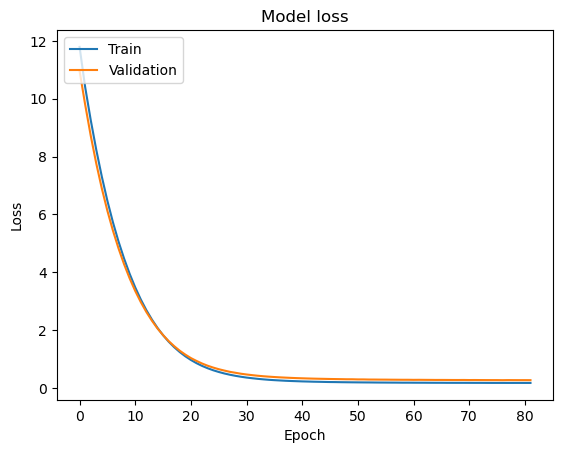

/work/brainvision_modelling3/models/stage_5/EBA/sub06
Completed ROI:  EBA sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub06
ROI_train shape:  (800, 119)
ROI_val shape:  (100, 119)
y_train shape:  (800, 119)
Y_val shape:  (100, 119)
Epoch 1/100
25/25 [==============================] - 11s 406ms/step - loss: 11.4489 - val_loss: 10.6268
Epoch 2/100
25/25 [==============================] - 10s 406ms/step - loss: 10.1950 - val_loss: 9.7317
Epoch 3/100
25/25 [==============================] - 10s 408ms/step - loss: 9.3018 - val_loss: 8.9484
Epoch 4/100
25/25 [==============================] - 10s 404ms/step - loss: 8.5424 - val_loss: 8.2648
Epoch 5/100
25/25 [==============================] - 10s 404ms/step - loss: 7.8769 - val_loss: 7.6580
Epoch 6/100
25/25 [==============================] - 10s 406ms/step - loss: 7.2846 - val_loss: 7.1081
Epoch 7/100
25/25 [==============================] - 10s 403ms/step - loss: 6.7456 

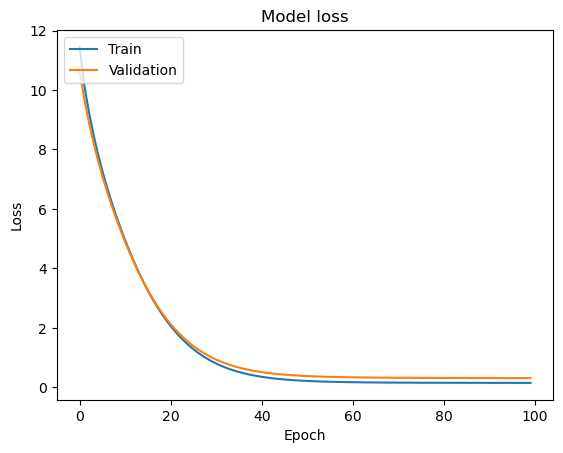

/work/brainvision_modelling3/models/stage_5/FFA/sub06
Completed ROI:  FFA sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub06
ROI_train shape:  (800, 173)
ROI_val shape:  (100, 173)
y_train shape:  (800, 173)
Y_val shape:  (100, 173)
Epoch 1/100
25/25 [==============================] - 11s 405ms/step - loss: 11.5007 - val_loss: 10.6877
Epoch 2/100
25/25 [==============================] - 10s 397ms/step - loss: 10.2090 - val_loss: 9.6967
Epoch 3/100
25/25 [==============================] - 10s 400ms/step - loss: 9.2335 - val_loss: 8.8041
Epoch 4/100
25/25 [==============================] - 10s 404ms/step - loss: 8.3746 - val_loss: 8.0100
Epoch 5/100
25/25 [==============================] - 10s 404ms/step - loss: 7.6043 - val_loss: 7.2984
Epoch 6/100
25/25 [==============================] - 10s 401ms/step - loss: 6.9103 - val_loss: 6.6547
Epoch 7/100
25/25 [==============================] - 10s 404ms/step - loss: 6.2827 

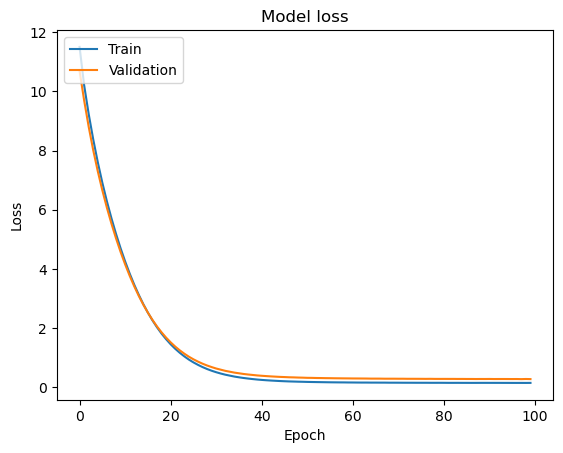

/work/brainvision_modelling3/models/stage_5/STS/sub06
Completed ROI:  STS sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub06
ROI_train shape:  (800, 216)
ROI_val shape:  (100, 216)
y_train shape:  (800, 216)
Y_val shape:  (100, 216)
Epoch 1/100
25/25 [==============================] - 11s 415ms/step - loss: 11.5696 - val_loss: 10.7451
Epoch 2/100
25/25 [==============================] - 10s 419ms/step - loss: 10.2428 - val_loss: 9.6953
Epoch 3/100
25/25 [==============================] - 10s 415ms/step - loss: 9.2119 - val_loss: 8.7346
Epoch 4/100
25/25 [==============================] - 10s 420ms/step - loss: 8.2881 - val_loss: 7.8721
Epoch 5/100
25/25 [==============================] - 10s 407ms/step - loss: 7.4571 - val_loss: 7.0974
Epoch 6/100
25/25 [==============================] - 10s 411ms/step - loss: 6.7081 - val_loss: 6.3990
Epoch 7/100
25/25 [==============================] - 10s 406ms/step - loss: 6.0299 

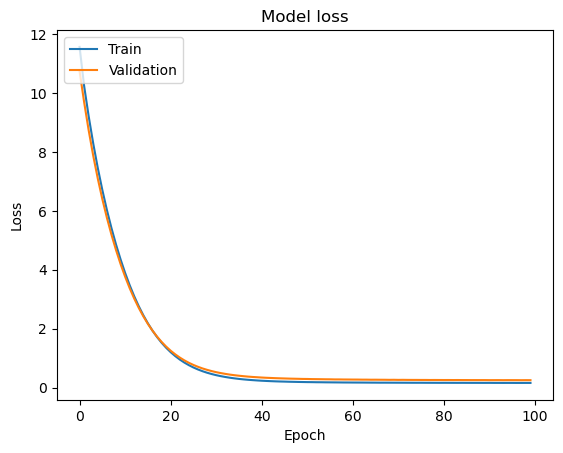

/work/brainvision_modelling3/models/stage_5/PPA/sub06
Completed ROI:  PPA sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub07
ROI_train shape:  (800, 10836)
ROI_val shape:  (100, 10836)
y_train shape:  (800, 10836)
Y_val shape:  (100, 10836)
Epoch 1/100
25/25 [==============================] - 31s 1s/step - loss: 26.0683 - val_loss: 21.6909
Epoch 2/100
25/25 [==============================] - 28s 1s/step - loss: 17.9048 - val_loss: 14.1945
Epoch 3/100
25/25 [==============================] - 29s 1s/step - loss: 11.5151 - val_loss: 8.9835
Epoch 4/100
25/25 [==============================] - 29s 1s/step - loss: 7.2185 - val_loss: 5.5763
Epoch 5/100
25/25 [==============================] - 29s 1s/step - loss: 4.4491 - val_loss: 3.4162
Epoch 6/100
25/25 [==============================] - 29s 1s/step - loss: 2.7142 - val_loss: 2.0826
Epoch 7/100
25/25 [==============================] - 29s 1s/step - loss: 1.6547 - val_loss: 

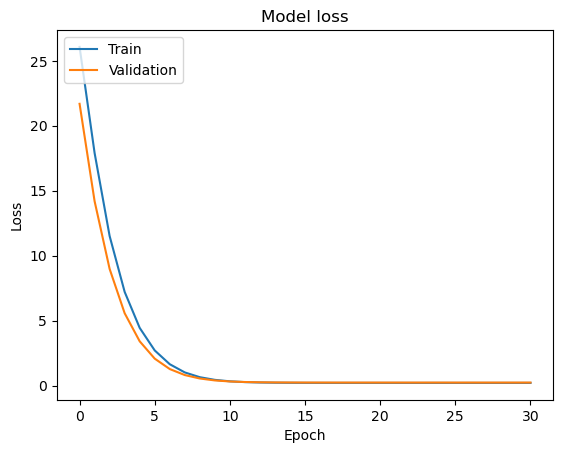

/work/brainvision_modelling3/models/stage_5/WB/sub07
Completed ROI:  WB sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub07
ROI_train shape:  (800, 195)
ROI_val shape:  (100, 195)
y_train shape:  (800, 195)
Y_val shape:  (100, 195)
Epoch 1/100
25/25 [==============================] - 6s 198ms/step - loss: 11.5891 - val_loss: 10.7731
Epoch 2/100
25/25 [==============================] - 5s 193ms/step - loss: 10.2801 - val_loss: 9.7743
Epoch 3/100
25/25 [==============================] - 5s 193ms/step - loss: 9.2970 - val_loss: 8.8730
Epoch 4/100
25/25 [==============================] - 5s 194ms/step - loss: 8.4286 - val_loss: 8.0700
Epoch 5/100
25/25 [==============================] - 5s 192ms/step - loss: 7.6496 - val_loss: 7.3503
Epoch 6/100
25/25 [==============================] - 5s 193ms/step - loss: 6.9470 - val_loss: 6.7004
Epoch 7/100
25/25 [==============================] - 5s 194ms/step - loss: 6.3110 - val_loss

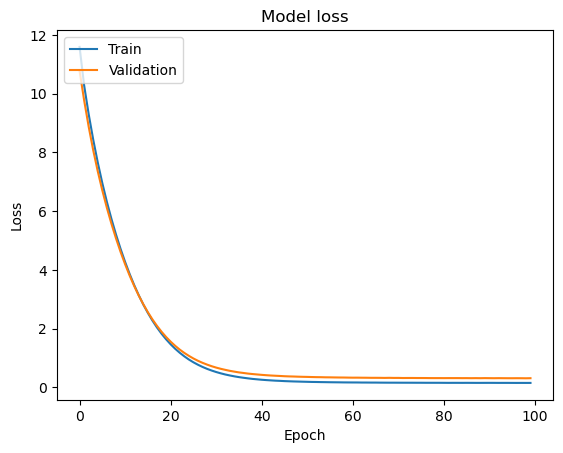

/work/brainvision_modelling3/models/stage_5/V1/sub07
Completed ROI:  V1 sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub07
ROI_train shape:  (800, 189)
ROI_val shape:  (100, 189)
y_train shape:  (800, 189)
Y_val shape:  (100, 189)
Epoch 1/100
25/25 [==============================] - 9s 345ms/step - loss: 11.5633 - val_loss: 10.7631
Epoch 2/100
25/25 [==============================] - 9s 344ms/step - loss: 10.2609 - val_loss: 9.7612
Epoch 3/100
25/25 [==============================] - 9s 348ms/step - loss: 9.2764 - val_loss: 8.8572
Epoch 4/100
25/25 [==============================] - 9s 345ms/step - loss: 8.4046 - val_loss: 8.0519
Epoch 5/100
25/25 [==============================] - 9s 346ms/step - loss: 7.6222 - val_loss: 7.3314
Epoch 6/100
25/25 [==============================] - 9s 348ms/step - loss: 6.9186 - val_loss: 6.6805
Epoch 7/100
25/25 [==============================] - 9s 340ms/step - loss: 6.2830 - val_loss

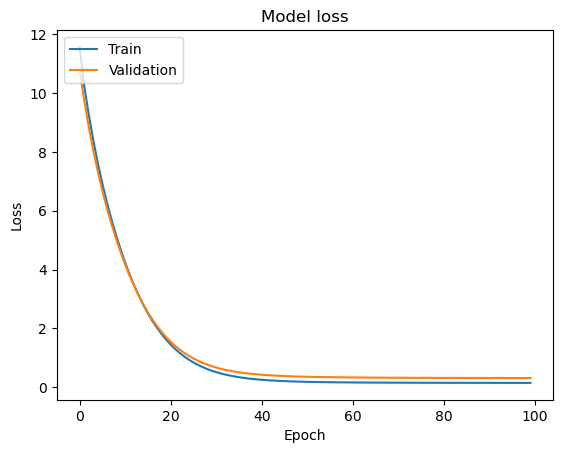

/work/brainvision_modelling3/models/stage_5/V2/sub07
Completed ROI:  V2 sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub07
ROI_train shape:  (800, 174)
ROI_val shape:  (100, 174)
y_train shape:  (800, 174)
Y_val shape:  (100, 174)
Epoch 1/100
25/25 [==============================] - 11s 420ms/step - loss: 11.5343 - val_loss: 10.7248
Epoch 2/100
25/25 [==============================] - 10s 411ms/step - loss: 10.2428 - val_loss: 9.7460
Epoch 3/100
25/25 [==============================] - 10s 412ms/step - loss: 9.2796 - val_loss: 8.8663
Epoch 4/100
25/25 [==============================] - 10s 418ms/step - loss: 8.4310 - val_loss: 8.0848
Epoch 5/100
25/25 [==============================] - 11s 420ms/step - loss: 7.6726 - val_loss: 7.3853
Epoch 6/100
25/25 [==============================] - 10s 417ms/step - loss: 6.9903 - val_loss: 6.7533
Epoch 7/100
25/25 [==============================] - 11s 421ms/step - loss: 6.3708 - v

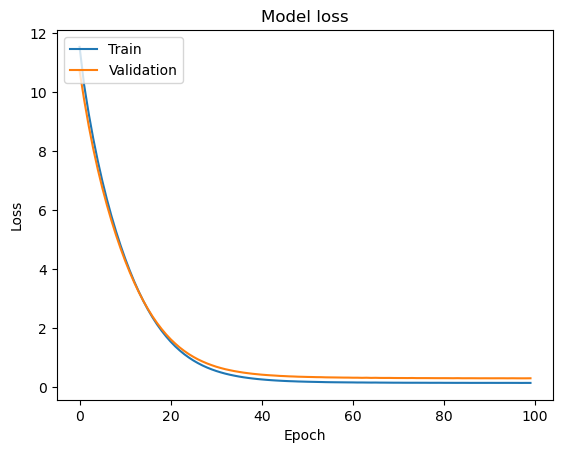

/work/brainvision_modelling3/models/stage_5/V3/sub07
Completed ROI:  V3 sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub07
ROI_train shape:  (800, 55)
ROI_val shape:  (100, 55)
y_train shape:  (800, 55)
Y_val shape:  (100, 55)
Epoch 1/100
25/25 [==============================] - 11s 420ms/step - loss: 11.3528 - val_loss: 10.5076
Epoch 2/100
25/25 [==============================] - 10s 406ms/step - loss: 10.1557 - val_loss: 9.7233
Epoch 3/100
25/25 [==============================] - 10s 408ms/step - loss: 9.3447 - val_loss: 9.0753
Epoch 4/100
25/25 [==============================] - 10s 406ms/step - loss: 8.7165 - val_loss: 8.5316
Epoch 5/100
25/25 [==============================] - 10s 405ms/step - loss: 8.1899 - val_loss: 8.0626
Epoch 6/100
25/25 [==============================] - 10s 408ms/step - loss: 7.7353 - val_loss: 7.6446
Epoch 7/100
25/25 [==============================] - 10s 410ms/step - loss: 7.3280 - val_l

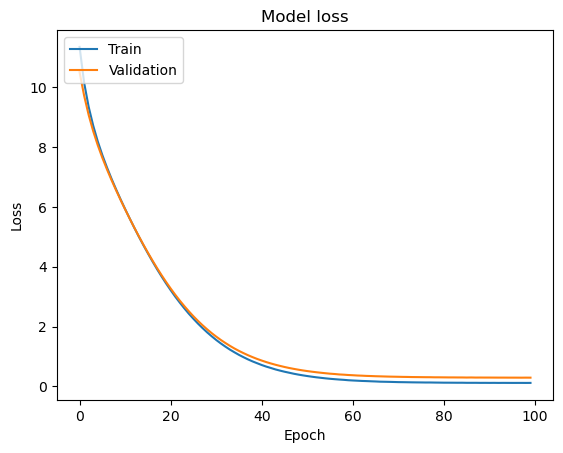

/work/brainvision_modelling3/models/stage_5/V4/sub07
Completed ROI:  V4 sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub07
ROI_train shape:  (800, 1117)
ROI_val shape:  (100, 1117)
y_train shape:  (800, 1117)
Y_val shape:  (100, 1117)
Epoch 1/100
25/25 [==============================] - 13s 479ms/step - loss: 13.3466 - val_loss: 12.3202
Epoch 2/100
25/25 [==============================] - 12s 468ms/step - loss: 11.4007 - val_loss: 10.4112
Epoch 3/100
25/25 [==============================] - 12s 467ms/step - loss: 9.5338 - val_loss: 8.6346
Epoch 4/100
25/25 [==============================] - 12s 468ms/step - loss: 7.8655 - val_loss: 7.0946
Epoch 5/100
25/25 [==============================] - 12s 465ms/step - loss: 6.4377 - val_loss: 5.7970
Epoch 6/100
25/25 [==============================] - 12s 463ms/step - loss: 5.2375 - val_loss: 4.7250
Epoch 7/100
25/25 [==============================] - 12s 465ms/step - loss: 4.23

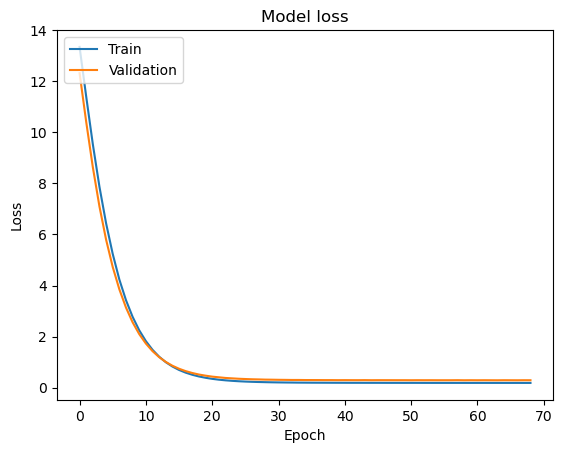

/work/brainvision_modelling3/models/stage_5/LOC/sub07
Completed ROI:  LOC sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub07
ROI_train shape:  (800, 101)
ROI_val shape:  (100, 101)
y_train shape:  (800, 101)
Y_val shape:  (100, 101)
Epoch 1/100
25/25 [==============================] - 11s 414ms/step - loss: 11.4411 - val_loss: 10.6316
Epoch 2/100
25/25 [==============================] - 10s 405ms/step - loss: 10.1975 - val_loss: 9.7642
Epoch 3/100
25/25 [==============================] - 10s 406ms/step - loss: 9.3285 - val_loss: 9.0146
Epoch 4/100
25/25 [==============================] - 10s 412ms/step - loss: 8.6005 - val_loss: 8.3653
Epoch 5/100
25/25 [==============================] - 10s 410ms/step - loss: 7.9703 - val_loss: 7.7944
Epoch 6/100
25/25 [==============================] - 10s 409ms/step - loss: 7.4128 - val_loss: 7.2795
Epoch 7/100
25/25 [==============================] - 10s 413ms/step - loss: 6.9084 

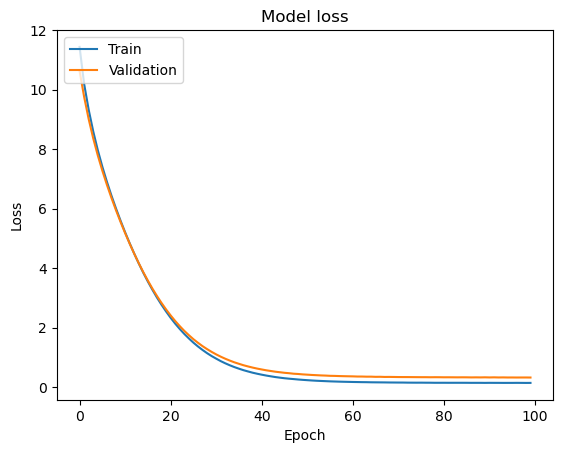

/work/brainvision_modelling3/models/stage_5/EBA/sub07
Completed ROI:  EBA sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub07
ROI_train shape:  (800, 89)
ROI_val shape:  (100, 89)
y_train shape:  (800, 89)
Y_val shape:  (100, 89)
Epoch 1/100
25/25 [==============================] - 11s 413ms/step - loss: 11.4039 - val_loss: 10.5728
Epoch 2/100
25/25 [==============================] - 10s 410ms/step - loss: 10.1670 - val_loss: 9.7297
Epoch 3/100
25/25 [==============================] - 10s 410ms/step - loss: 9.3222 - val_loss: 9.0089
Epoch 4/100
25/25 [==============================] - 10s 408ms/step - loss: 8.6259 - val_loss: 8.3884
Epoch 5/100
25/25 [==============================] - 10s 403ms/step - loss: 8.0247 - val_loss: 7.8433
Epoch 6/100
25/25 [==============================] - 10s 418ms/step - loss: 7.4935 - val_loss: 7.3528
Epoch 7/100
25/25 [==============================] - 10s 415ms/step - loss: 7.0120 - va

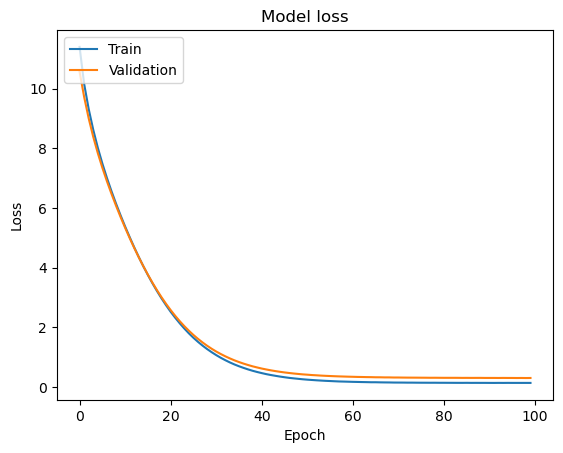

/work/brainvision_modelling3/models/stage_5/FFA/sub07
Completed ROI:  FFA sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub07
ROI_train shape:  (800, 80)
ROI_val shape:  (100, 80)
y_train shape:  (800, 80)
Y_val shape:  (100, 80)
Epoch 1/100
25/25 [==============================] - 11s 408ms/step - loss: 11.3993 - val_loss: 10.5492
Epoch 2/100
25/25 [==============================] - 10s 406ms/step - loss: 10.1699 - val_loss: 9.7196
Epoch 3/100
25/25 [==============================] - 10s 402ms/step - loss: 9.3301 - val_loss: 9.0163
Epoch 4/100
25/25 [==============================] - 10s 408ms/step - loss: 8.6474 - val_loss: 8.4155
Epoch 5/100
25/25 [==============================] - 10s 404ms/step - loss: 8.0637 - val_loss: 7.8886
Epoch 6/100
25/25 [==============================] - 10s 402ms/step - loss: 7.5505 - val_loss: 7.4150
Epoch 7/100
25/25 [==============================] - 10s 401ms/step - loss: 7.0852 - va

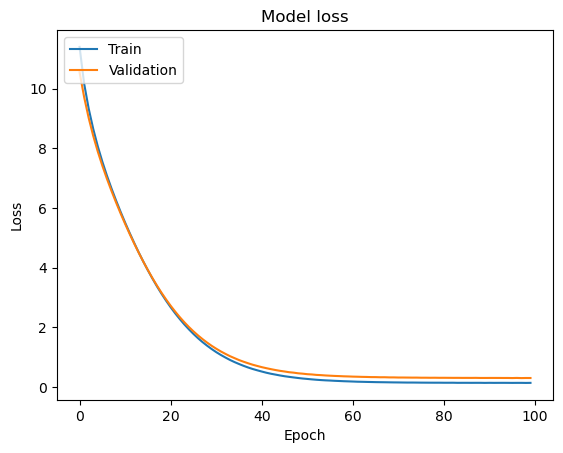

/work/brainvision_modelling3/models/stage_5/STS/sub07
Completed ROI:  STS sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub07
ROI_train shape:  (800, 33)
ROI_val shape:  (100, 33)
y_train shape:  (800, 33)
Y_val shape:  (100, 33)
Epoch 1/100
25/25 [==============================] - 11s 396ms/step - loss: 11.3351 - val_loss: 10.4424
Epoch 2/100
25/25 [==============================] - 10s 400ms/step - loss: 10.1935 - val_loss: 9.7056
Epoch 3/100
25/25 [==============================] - 10s 403ms/step - loss: 9.3866 - val_loss: 9.1191
Epoch 4/100
25/25 [==============================] - 10s 396ms/step - loss: 8.8139 - val_loss: 8.6429
Epoch 5/100
25/25 [==============================] - 10s 396ms/step - loss: 8.3563 - val_loss: 8.2431
Epoch 6/100
25/25 [==============================] - 10s 388ms/step - loss: 7.9678 - val_loss: 7.8946
Epoch 7/100
25/25 [==============================] - 10s 399ms/step - loss: 7.6321 - va

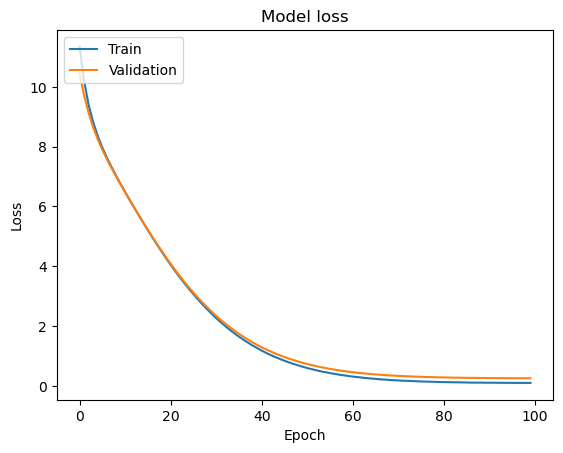

/work/brainvision_modelling3/models/stage_5/PPA/sub07
Completed ROI:  PPA sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub08
ROI_train shape:  (800, 12347)
ROI_val shape:  (100, 12347)
y_train shape:  (800, 12347)
Y_val shape:  (100, 12347)
Epoch 1/100
25/25 [==============================] - 49s 2s/step - loss: 27.7220 - val_loss: 22.7552
Epoch 2/100
25/25 [==============================] - 48s 2s/step - loss: 18.5775 - val_loss: 14.4950
Epoch 3/100
25/25 [==============================] - 47s 2s/step - loss: 11.6309 - val_loss: 8.9212
Epoch 4/100
25/25 [==============================] - 48s 2s/step - loss: 7.0945 - val_loss: 5.3820
Epoch 5/100
25/25 [==============================] - 47s 2s/step - loss: 4.2549 - val_loss: 3.2033
Epoch 6/100
25/25 [==============================] - 47s 2s/step - loss: 2.5281 - val_loss: 1.9009
Epoch 7/100
25/25 [==============================] - 47s 2s/step - loss: 1.5042 - val_loss: 

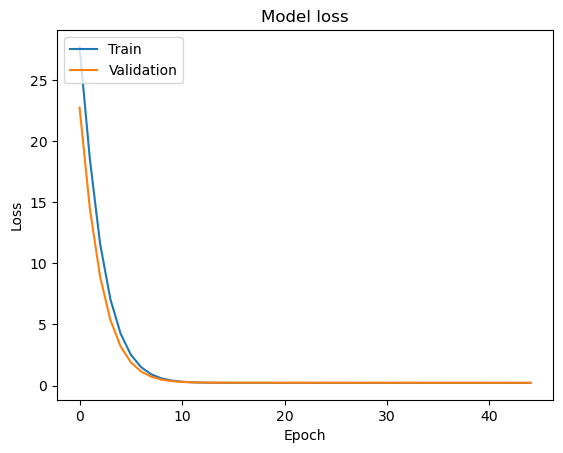

/work/brainvision_modelling3/models/stage_5/WB/sub08
Completed ROI:  WB sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub08
ROI_train shape:  (800, 300)
ROI_val shape:  (100, 300)
y_train shape:  (800, 300)
Y_val shape:  (100, 300)
Epoch 1/100
25/25 [==============================] - 11s 408ms/step - loss: 11.7962 - val_loss: 10.9534
Epoch 2/100
25/25 [==============================] - 10s 409ms/step - loss: 10.4204 - val_loss: 9.8218
Epoch 3/100
25/25 [==============================] - 10s 402ms/step - loss: 9.3059 - val_loss: 8.7741
Epoch 4/100
25/25 [==============================] - 10s 404ms/step - loss: 8.2976 - val_loss: 7.8327
Epoch 5/100
25/25 [==============================] - 10s 408ms/step - loss: 7.3897 - val_loss: 6.9906
Epoch 6/100
25/25 [==============================] - 10s 406ms/step - loss: 6.5746 - val_loss: 6.2392
Epoch 7/100
25/25 [==============================] - 10s 403ms/step - loss: 5.8447 - v

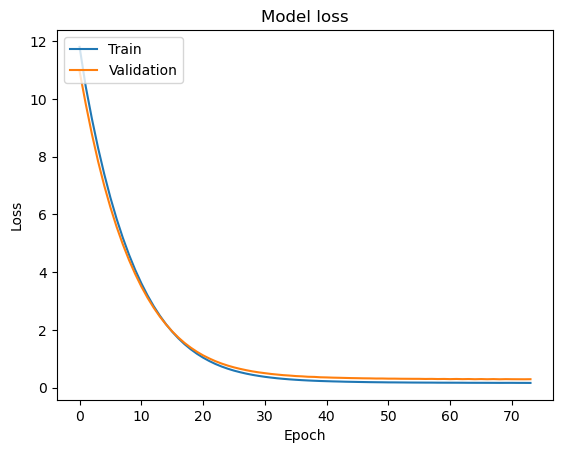

/work/brainvision_modelling3/models/stage_5/V1/sub08
Completed ROI:  V1 sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub08
ROI_train shape:  (800, 238)
ROI_val shape:  (100, 238)
y_train shape:  (800, 238)
Y_val shape:  (100, 238)
Epoch 1/100
25/25 [==============================] - 11s 429ms/step - loss: 11.6502 - val_loss: 10.8190
Epoch 2/100
25/25 [==============================] - 11s 425ms/step - loss: 10.3134 - val_loss: 9.7466
Epoch 3/100
25/25 [==============================] - 10s 419ms/step - loss: 9.2590 - val_loss: 8.7631
Epoch 4/100
25/25 [==============================] - 10s 414ms/step - loss: 8.3121 - val_loss: 7.8817
Epoch 5/100
25/25 [==============================] - 10s 416ms/step - loss: 7.4603 - val_loss: 7.0927
Epoch 6/100
25/25 [==============================] - 11s 423ms/step - loss: 6.6940 - val_loss: 6.3843
Epoch 7/100
25/25 [==============================] - 10s 417ms/step - loss: 6.0050 - v

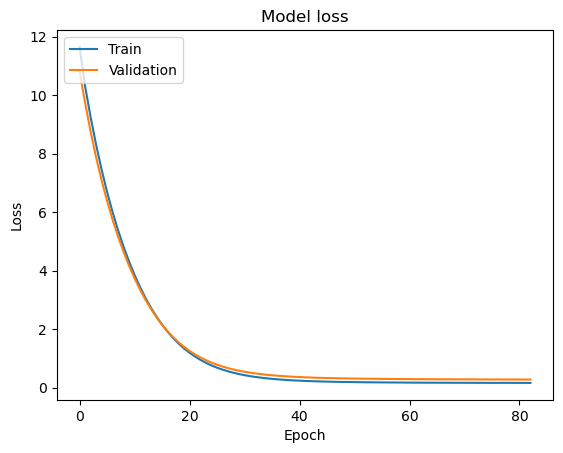

/work/brainvision_modelling3/models/stage_5/V2/sub08
Completed ROI:  V2 sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub08
ROI_train shape:  (800, 223)
ROI_val shape:  (100, 223)
y_train shape:  (800, 223)
Y_val shape:  (100, 223)
Epoch 1/100
25/25 [==============================] - 11s 401ms/step - loss: 11.6284 - val_loss: 10.7923
Epoch 2/100
25/25 [==============================] - 10s 404ms/step - loss: 10.3006 - val_loss: 9.7495
Epoch 3/100
25/25 [==============================] - 10s 403ms/step - loss: 9.2762 - val_loss: 8.7984
Epoch 4/100
25/25 [==============================] - 10s 399ms/step - loss: 8.3609 - val_loss: 7.9473
Epoch 5/100
25/25 [==============================] - 10s 401ms/step - loss: 7.5389 - val_loss: 7.1838
Epoch 6/100
25/25 [==============================] - 10s 400ms/step - loss: 6.7978 - val_loss: 6.4963
Epoch 7/100
25/25 [==============================] - 10s 399ms/step - loss: 6.1282 - v

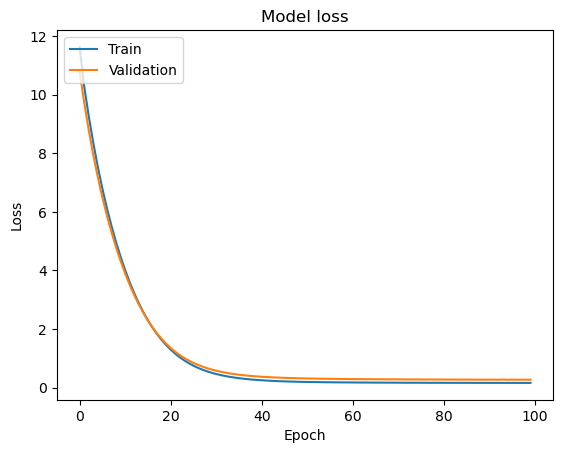

/work/brainvision_modelling3/models/stage_5/V3/sub08
Completed ROI:  V3 sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub08
ROI_train shape:  (800, 85)
ROI_val shape:  (100, 85)
y_train shape:  (800, 85)
Y_val shape:  (100, 85)
Epoch 1/100
25/25 [==============================] - 11s 411ms/step - loss: 11.3920 - val_loss: 10.5362
Epoch 2/100
25/25 [==============================] - 10s 404ms/step - loss: 10.1608 - val_loss: 9.6955
Epoch 3/100
25/25 [==============================] - 10s 404ms/step - loss: 9.3173 - val_loss: 8.9791
Epoch 4/100
25/25 [==============================] - 10s 412ms/step - loss: 8.6246 - val_loss: 8.3636
Epoch 5/100
25/25 [==============================] - 10s 407ms/step - loss: 8.0246 - val_loss: 7.8221
Epoch 6/100
25/25 [==============================] - 10s 408ms/step - loss: 7.4951 - val_loss: 7.3338
Epoch 7/100
25/25 [==============================] - 10s 405ms/step - loss: 7.0162 - val_l

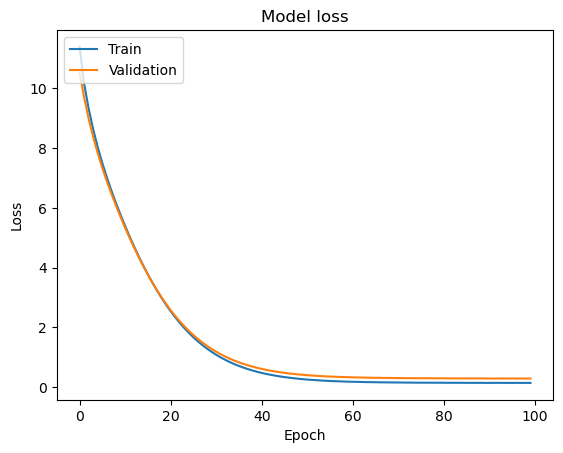

/work/brainvision_modelling3/models/stage_5/V4/sub08
Completed ROI:  V4 sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub08
ROI_train shape:  (800, 1244)
ROI_val shape:  (100, 1244)
y_train shape:  (800, 1244)
Y_val shape:  (100, 1244)
Epoch 1/100
25/25 [==============================] - 13s 470ms/step - loss: 13.5647 - val_loss: 12.4809
Epoch 2/100
25/25 [==============================] - 12s 466ms/step - loss: 11.5242 - val_loss: 10.4616
Epoch 3/100
25/25 [==============================] - 12s 474ms/step - loss: 9.5565 - val_loss: 8.5964
Epoch 4/100
25/25 [==============================] - 12s 465ms/step - loss: 7.8132 - val_loss: 6.9952
Epoch 5/100
25/25 [==============================] - 12s 466ms/step - loss: 6.3354 - val_loss: 5.6589
Epoch 6/100
25/25 [==============================] - 12s 466ms/step - loss: 5.1044 - val_loss: 4.5645
Epoch 7/100
25/25 [==============================] - 12s 462ms/step - loss: 4.09

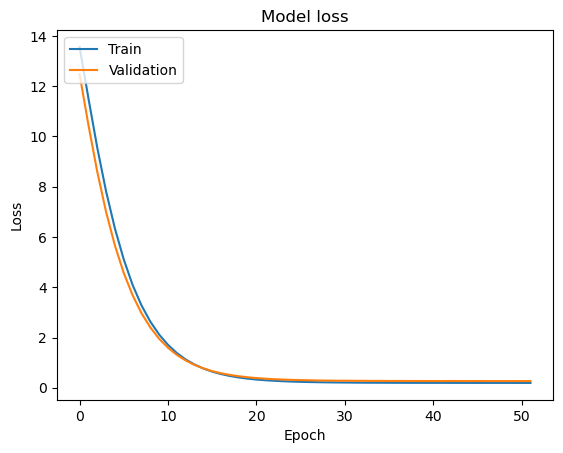

/work/brainvision_modelling3/models/stage_5/LOC/sub08
Completed ROI:  LOC sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub08
ROI_train shape:  (800, 55)
ROI_val shape:  (100, 55)
y_train shape:  (800, 55)
Y_val shape:  (100, 55)
Epoch 1/100
25/25 [==============================] - 11s 401ms/step - loss: 11.3908 - val_loss: 10.5294
Epoch 2/100
25/25 [==============================] - 10s 391ms/step - loss: 10.1796 - val_loss: 9.7502
Epoch 3/100
25/25 [==============================] - 10s 388ms/step - loss: 9.3695 - val_loss: 9.1077
Epoch 4/100
25/25 [==============================] - 10s 392ms/step - loss: 8.7472 - val_loss: 8.5708
Epoch 5/100
25/25 [==============================] - 10s 390ms/step - loss: 8.2297 - val_loss: 8.1098
Epoch 6/100
25/25 [==============================] - 10s 392ms/step - loss: 7.7836 - val_loss: 7.7016
Epoch 7/100
25/25 [==============================] - 10s 388ms/step - loss: 7.3828 - va

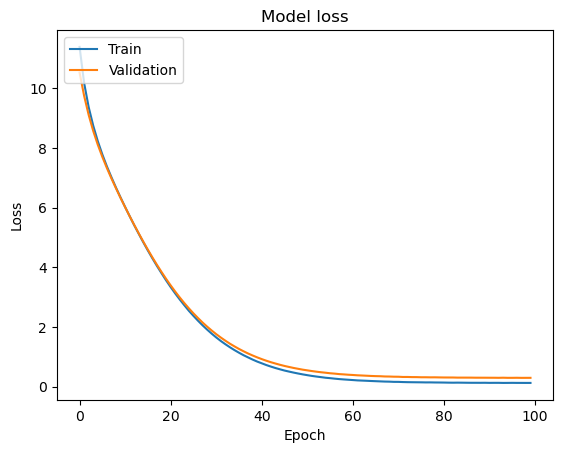

/work/brainvision_modelling3/models/stage_5/EBA/sub08
Completed ROI:  EBA sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub08
ROI_train shape:  (800, 163)
ROI_val shape:  (100, 163)
y_train shape:  (800, 163)
Y_val shape:  (100, 163)
Epoch 1/100
25/25 [==============================] - 11s 403ms/step - loss: 11.5331 - val_loss: 10.6983
Epoch 2/100
25/25 [==============================] - 10s 392ms/step - loss: 10.2458 - val_loss: 9.7382
Epoch 3/100
25/25 [==============================] - 10s 390ms/step - loss: 9.2967 - val_loss: 8.8777
Epoch 4/100
25/25 [==============================] - 10s 393ms/step - loss: 8.4651 - val_loss: 8.1156
Epoch 5/100
25/25 [==============================] - 10s 394ms/step - loss: 7.7257 - val_loss: 7.4356
Epoch 6/100
25/25 [==============================] - 10s 399ms/step - loss: 7.0632 - val_loss: 6.8212
Epoch 7/100
25/25 [==============================] - 10s 396ms/step - loss: 6.4640 

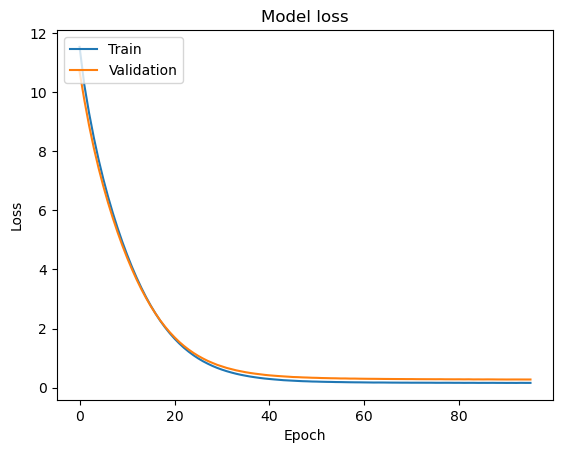

/work/brainvision_modelling3/models/stage_5/FFA/sub08
Completed ROI:  FFA sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub08
ROI_train shape:  (800, 306)
ROI_val shape:  (100, 306)
y_train shape:  (800, 306)
Y_val shape:  (100, 306)
Epoch 1/100
25/25 [==============================] - 11s 418ms/step - loss: 11.8046 - val_loss: 10.9748
Epoch 2/100
25/25 [==============================] - 10s 414ms/step - loss: 10.4224 - val_loss: 9.8305
Epoch 3/100
25/25 [==============================] - 10s 415ms/step - loss: 9.2949 - val_loss: 8.7680
Epoch 4/100
25/25 [==============================] - 10s 414ms/step - loss: 8.2706 - val_loss: 7.8113
Epoch 5/100
25/25 [==============================] - 10s 414ms/step - loss: 7.3473 - val_loss: 6.9547
Epoch 6/100
25/25 [==============================] - 10s 417ms/step - loss: 6.5200 - val_loss: 6.1917
Epoch 7/100
25/25 [==============================] - 10s 409ms/step - loss: 5.7834 

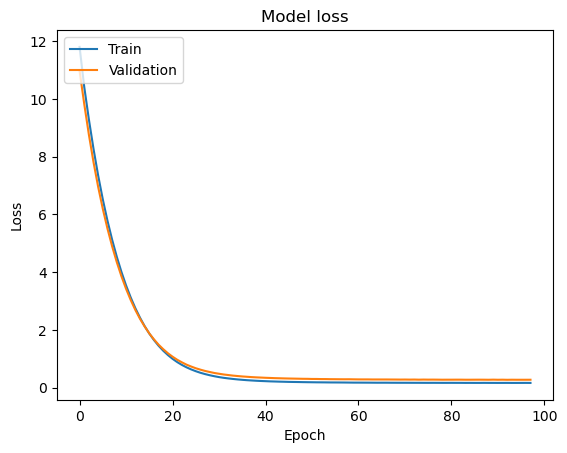

/work/brainvision_modelling3/models/stage_5/STS/sub08
Completed ROI:  STS sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub08
ROI_train shape:  (800, 150)
ROI_val shape:  (100, 150)
y_train shape:  (800, 150)
Y_val shape:  (100, 150)
Epoch 1/100
25/25 [==============================] - 11s 404ms/step - loss: 11.4547 - val_loss: 10.6207
Epoch 2/100
25/25 [==============================] - 10s 408ms/step - loss: 10.1740 - val_loss: 9.6670
Epoch 3/100
25/25 [==============================] - 10s 400ms/step - loss: 9.2365 - val_loss: 8.8164
Epoch 4/100
25/25 [==============================] - 10s 402ms/step - loss: 8.4195 - val_loss: 8.0626
Epoch 5/100
25/25 [==============================] - 10s 403ms/step - loss: 7.6904 - val_loss: 7.3876
Epoch 6/100
25/25 [==============================] - 10s 399ms/step - loss: 7.0333 - val_loss: 6.7761
Epoch 7/100
25/25 [==============================] - 10s 399ms/step - loss: 6.4363 

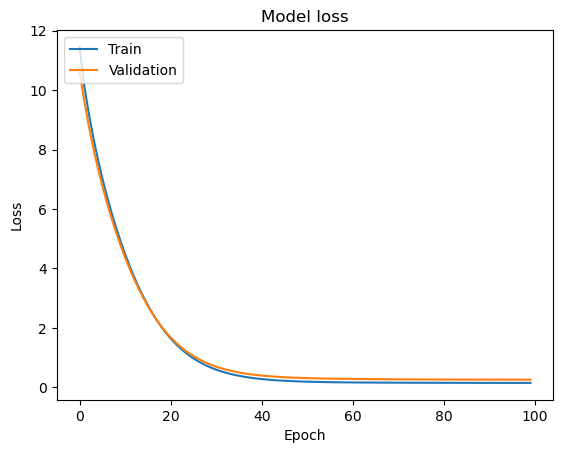

/work/brainvision_modelling3/models/stage_5/PPA/sub08
Completed ROI:  PPA sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub09
ROI_train shape:  (800, 17570)
ROI_val shape:  (100, 17570)
y_train shape:  (800, 17570)
Y_val shape:  (100, 17570)
Epoch 1/100
25/25 [==============================] - 74s 3s/step - loss: 33.3292 - val_loss: 26.4211
Epoch 2/100
25/25 [==============================] - 73s 3s/step - loss: 20.8733 - val_loss: 15.6126
Epoch 3/100
25/25 [==============================] - 73s 3s/step - loss: 12.0978 - val_loss: 8.8778
Epoch 4/100
25/25 [==============================] - 73s 3s/step - loss: 6.8113 - val_loss: 4.9408
Epoch 5/100
25/25 [==============================] - 73s 3s/step - loss: 3.7687 - val_loss: 2.7167
Epoch 6/100
25/25 [==============================] - 72s 3s/step - loss: 2.0728 - val_loss: 1.4990
Epoch 7/100
25/25 [==============================] - 73s 3s/step - loss: 1.1559 - val_loss: 

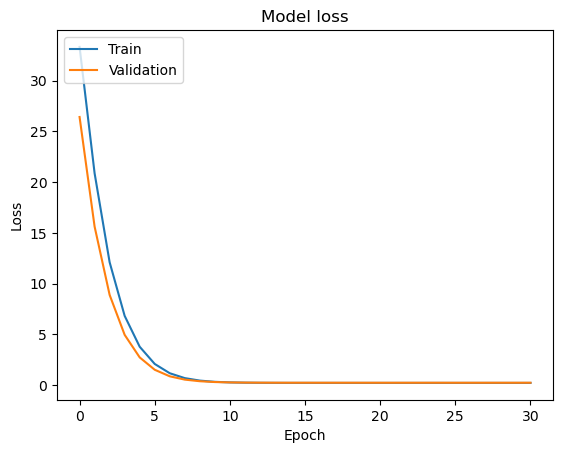

/work/brainvision_modelling3/models/stage_5/WB/sub09
Completed ROI:  WB sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub09
ROI_train shape:  (800, 271)
ROI_val shape:  (100, 271)
y_train shape:  (800, 271)
Y_val shape:  (100, 271)
Epoch 1/100
25/25 [==============================] - 10s 342ms/step - loss: 11.7087 - val_loss: 10.8717
Epoch 2/100
25/25 [==============================] - 9s 343ms/step - loss: 10.3441 - val_loss: 9.7556
Epoch 3/100
25/25 [==============================] - 9s 342ms/step - loss: 9.2470 - val_loss: 8.7244
Epoch 4/100
25/25 [==============================] - 9s 350ms/step - loss: 8.2559 - val_loss: 7.7974
Epoch 5/100
25/25 [==============================] - 8s 338ms/step - loss: 7.3631 - val_loss: 6.9668
Epoch 6/100
25/25 [==============================] - 8s 338ms/step - loss: 6.5603 - val_loss: 6.2239
Epoch 7/100
25/25 [==============================] - 8s 338ms/step - loss: 5.8395 - val_los

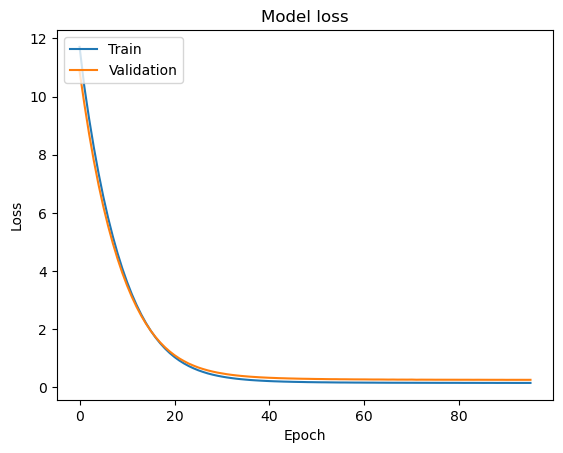

/work/brainvision_modelling3/models/stage_5/V1/sub09
Completed ROI:  V1 sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub09
ROI_train shape:  (800, 265)
ROI_val shape:  (100, 265)
y_train shape:  (800, 265)
Y_val shape:  (100, 265)
Epoch 1/100
25/25 [==============================] - 11s 419ms/step - loss: 11.7035 - val_loss: 10.8651
Epoch 2/100
25/25 [==============================] - 10s 418ms/step - loss: 10.3446 - val_loss: 9.7657
Epoch 3/100
25/25 [==============================] - 10s 416ms/step - loss: 9.2646 - val_loss: 8.7524
Epoch 4/100
25/25 [==============================] - 10s 410ms/step - loss: 8.2905 - val_loss: 7.8414
Epoch 5/100
25/25 [==============================] - 10s 416ms/step - loss: 7.4133 - val_loss: 7.0250
Epoch 6/100
25/25 [==============================] - 10s 415ms/step - loss: 6.6233 - val_loss: 6.2930
Epoch 7/100
25/25 [==============================] - 10s 408ms/step - loss: 5.9128 - v

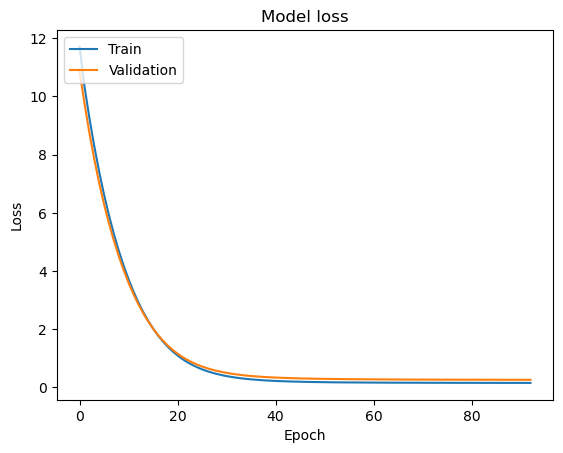

/work/brainvision_modelling3/models/stage_5/V2/sub09
Completed ROI:  V2 sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub09
ROI_train shape:  (800, 245)
ROI_val shape:  (100, 245)
y_train shape:  (800, 245)
Y_val shape:  (100, 245)
Epoch 1/100
25/25 [==============================] - 11s 415ms/step - loss: 11.6602 - val_loss: 10.8324
Epoch 2/100
25/25 [==============================] - 10s 410ms/step - loss: 10.3164 - val_loss: 9.7553
Epoch 3/100
25/25 [==============================] - 10s 413ms/step - loss: 9.2575 - val_loss: 8.7663
Epoch 4/100
25/25 [==============================] - 10s 412ms/step - loss: 8.3053 - val_loss: 7.8792
Epoch 5/100
25/25 [==============================] - 10s 413ms/step - loss: 7.4485 - val_loss: 7.0845
Epoch 6/100
25/25 [==============================] - 10s 410ms/step - loss: 6.6780 - val_loss: 6.3709
Epoch 7/100
25/25 [==============================] - 10s 411ms/step - loss: 5.9847 - v

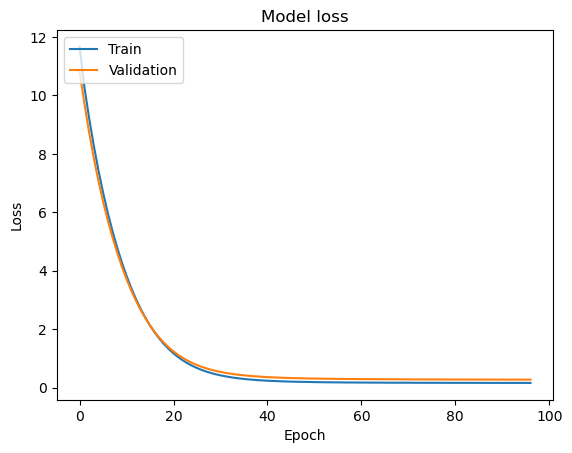

/work/brainvision_modelling3/models/stage_5/V3/sub09
Completed ROI:  V3 sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub09
ROI_train shape:  (800, 94)
ROI_val shape:  (100, 94)
y_train shape:  (800, 94)
Y_val shape:  (100, 94)
Epoch 1/100
25/25 [==============================] - 11s 406ms/step - loss: 11.4059 - val_loss: 10.5637
Epoch 2/100
25/25 [==============================] - 10s 401ms/step - loss: 10.1675 - val_loss: 9.7104
Epoch 3/100
25/25 [==============================] - 10s 402ms/step - loss: 9.3130 - val_loss: 8.9786
Epoch 4/100
25/25 [==============================] - 10s 400ms/step - loss: 8.6050 - val_loss: 8.3462
Epoch 5/100
25/25 [==============================] - 10s 407ms/step - loss: 7.9914 - val_loss: 7.7887
Epoch 6/100
25/25 [==============================] - 10s 404ms/step - loss: 7.4487 - val_loss: 7.2862
Epoch 7/100
25/25 [==============================] - 10s 405ms/step - loss: 6.9551 - val_l

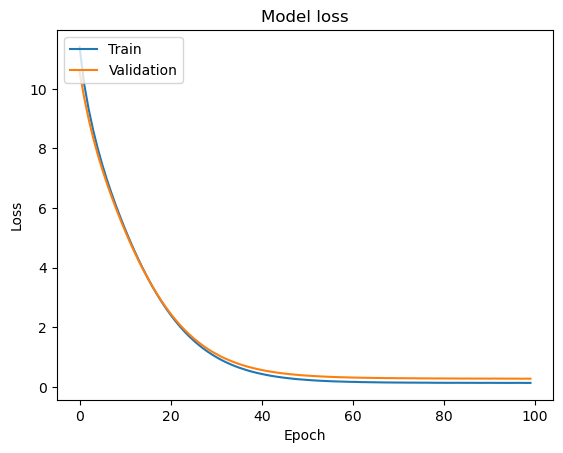

/work/brainvision_modelling3/models/stage_5/V4/sub09
Completed ROI:  V4 sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub09
ROI_train shape:  (800, 1515)
ROI_val shape:  (100, 1515)
y_train shape:  (800, 1515)
Y_val shape:  (100, 1515)
Epoch 1/100
25/25 [==============================] - 13s 473ms/step - loss: 14.0018 - val_loss: 12.8406
Epoch 2/100
25/25 [==============================] - 12s 475ms/step - loss: 11.7644 - val_loss: 10.5986
Epoch 3/100
25/25 [==============================] - 12s 474ms/step - loss: 9.5946 - val_loss: 8.5564
Epoch 4/100
25/25 [==============================] - 12s 479ms/step - loss: 7.7007 - val_loss: 6.8306
Epoch 5/100
25/25 [==============================] - 12s 476ms/step - loss: 6.1229 - val_loss: 5.4150
Epoch 6/100
25/25 [==============================] - 12s 478ms/step - loss: 4.8352 - val_loss: 4.2764
Epoch 7/100
25/25 [==============================] - 12s 478ms/step - loss: 3.79

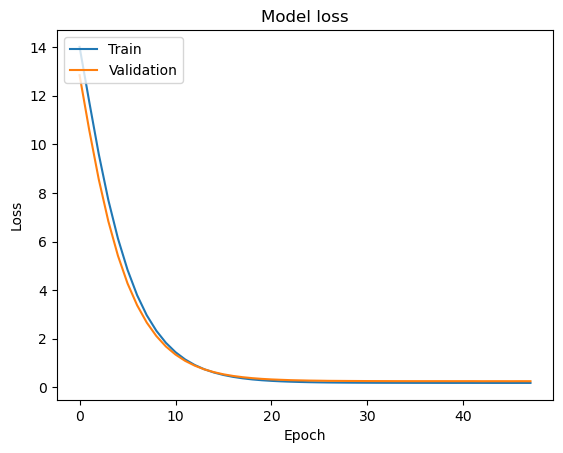

/work/brainvision_modelling3/models/stage_5/LOC/sub09
Completed ROI:  LOC sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub09
ROI_train shape:  (800, 191)
ROI_val shape:  (100, 191)
y_train shape:  (800, 191)
Y_val shape:  (100, 191)
Epoch 1/100
25/25 [==============================] - 11s 417ms/step - loss: 11.5886 - val_loss: 10.7517
Epoch 2/100
25/25 [==============================] - 10s 408ms/step - loss: 10.2817 - val_loss: 9.7538
Epoch 3/100
25/25 [==============================] - 10s 407ms/step - loss: 9.2970 - val_loss: 8.8525
Epoch 4/100
25/25 [==============================] - 10s 410ms/step - loss: 8.4231 - val_loss: 8.0507
Epoch 5/100
25/25 [==============================] - 10s 410ms/step - loss: 7.6436 - val_loss: 7.3338
Epoch 6/100
25/25 [==============================] - 10s 407ms/step - loss: 6.9444 - val_loss: 6.6862
Epoch 7/100
25/25 [==============================] - 10s 411ms/step - loss: 6.3126 

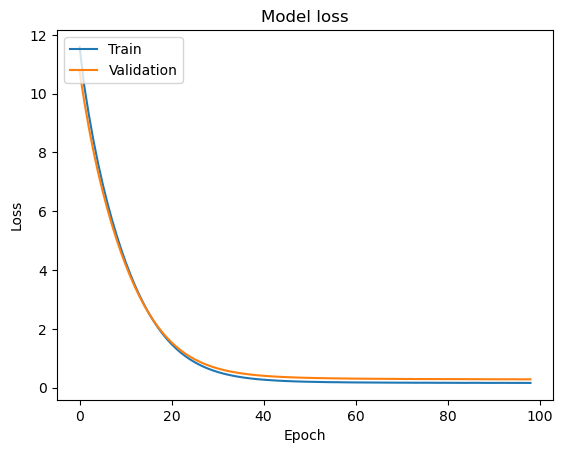

/work/brainvision_modelling3/models/stage_5/EBA/sub09
Completed ROI:  EBA sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub09
ROI_train shape:  (800, 76)
ROI_val shape:  (100, 76)
y_train shape:  (800, 76)
Y_val shape:  (100, 76)
Epoch 1/100
25/25 [==============================] - 11s 403ms/step - loss: 11.3719 - val_loss: 10.5084
Epoch 2/100
25/25 [==============================] - 10s 397ms/step - loss: 10.1473 - val_loss: 9.6844
Epoch 3/100
25/25 [==============================] - 10s 399ms/step - loss: 9.3145 - val_loss: 8.9868
Epoch 4/100
25/25 [==============================] - 10s 404ms/step - loss: 8.6428 - val_loss: 8.3907
Epoch 5/100
25/25 [==============================] - 10s 399ms/step - loss: 8.0676 - val_loss: 7.8695
Epoch 6/100
25/25 [==============================] - 10s 404ms/step - loss: 7.5596 - val_loss: 7.4002
Epoch 7/100
25/25 [==============================] - 10s 403ms/step - loss: 7.1013 - va

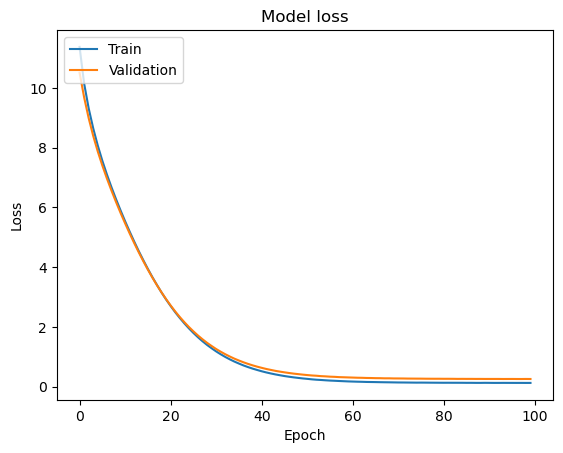

/work/brainvision_modelling3/models/stage_5/FFA/sub09
Completed ROI:  FFA sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub09
ROI_train shape:  (800, 346)
ROI_val shape:  (100, 346)
y_train shape:  (800, 346)
Y_val shape:  (100, 346)
Epoch 1/100
25/25 [==============================] - 11s 415ms/step - loss: 11.8395 - val_loss: 10.9841
Epoch 2/100
25/25 [==============================] - 10s 416ms/step - loss: 10.4211 - val_loss: 9.7823
Epoch 3/100
25/25 [==============================] - 10s 416ms/step - loss: 9.2386 - val_loss: 8.6591
Epoch 4/100
25/25 [==============================] - 10s 414ms/step - loss: 8.1612 - val_loss: 7.6460
Epoch 5/100
25/25 [==============================] - 10s 416ms/step - loss: 7.1928 - val_loss: 6.7413
Epoch 6/100
25/25 [==============================] - 10s 415ms/step - loss: 6.3263 - val_loss: 5.9372
Epoch 7/100
25/25 [==============================] - 11s 423ms/step - loss: 5.5539 

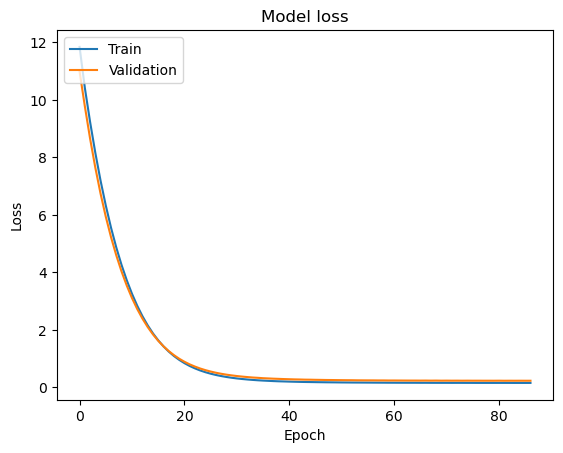

/work/brainvision_modelling3/models/stage_5/STS/sub09
Completed ROI:  STS sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub09
ROI_train shape:  (800, 262)
ROI_val shape:  (100, 262)
y_train shape:  (800, 262)
Y_val shape:  (100, 262)
Epoch 1/100
25/25 [==============================] - 11s 416ms/step - loss: 11.6390 - val_loss: 10.8124
Epoch 2/100
25/25 [==============================] - 10s 408ms/step - loss: 10.2787 - val_loss: 9.6937
Epoch 3/100
25/25 [==============================] - 10s 414ms/step - loss: 9.1793 - val_loss: 8.6577
Epoch 4/100
25/25 [==============================] - 10s 411ms/step - loss: 8.1857 - val_loss: 7.7238
Epoch 5/100
25/25 [==============================] - 10s 417ms/step - loss: 7.2899 - val_loss: 6.8853
Epoch 6/100
25/25 [==============================] - 10s 412ms/step - loss: 6.4845 - val_loss: 6.1330
Epoch 7/100
25/25 [==============================] - 11s 421ms/step - loss: 5.7598 

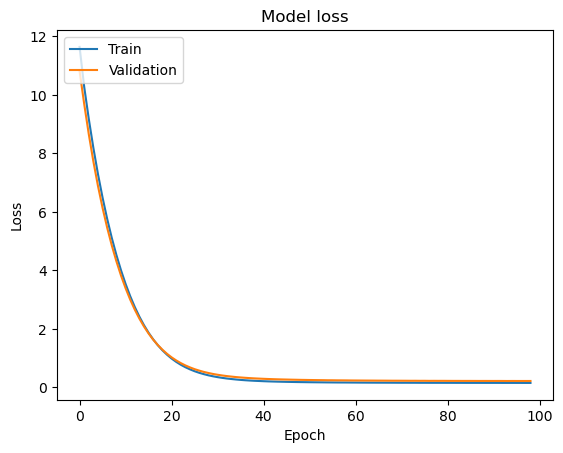

/work/brainvision_modelling3/models/stage_5/PPA/sub09
Completed ROI:  PPA sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub10
ROI_train shape:  (800, 12950)
ROI_val shape:  (100, 12950)
y_train shape:  (800, 12950)
Y_val shape:  (100, 12950)
Epoch 1/100
25/25 [==============================] - 51s 2s/step - loss: 28.3991 - val_loss: 23.2154
Epoch 2/100
25/25 [==============================] - 50s 2s/step - loss: 18.8838 - val_loss: 14.6578
Epoch 3/100
25/25 [==============================] - 50s 2s/step - loss: 11.7163 - val_loss: 8.9361
Epoch 4/100
25/25 [==============================] - 50s 2s/step - loss: 7.0791 - val_loss: 5.3374
Epoch 5/100
25/25 [==============================] - 50s 2s/step - loss: 4.2044 - val_loss: 3.1440
Epoch 6/100
25/25 [==============================] - 50s 2s/step - loss: 2.4742 - val_loss: 1.8448
Epoch 7/100
25/25 [==============================] - 50s 2s/step - loss: 1.4609 - val_loss: 

In [ ]:
# conduct training & evaluation
# if evaluation should be started before all models are trained (with all models that have been trained so far), this can be done via simply calling "run evaluation pipeline" separately (via evaluation.ipynb)
print("GPU available:", tf.config.list_physical_devices('GPU'))
if __name__ == "__main__":
    if tf.test.is_gpu_available():
        with tf.device('/GPU:0'):
            run_training_pipeline(hpo=True)
            run_evaluation_pipeline(data_mode="val")
    else:
        run_training_pipeline(hpo=False)
        run_evaluation_pipeline(data_mode="val")

### Summarize Training Results

In [ ]:
# load all training results from all separate server sessions into a single folder
results_path = "validation_results"

aggregated_results = [file for file in os.listdir(results_path) if "aggregated" in file]

results_list =[]
for file_name in aggregated_results:
    file_path = os.joindir(results_path, file_name)
    df = pd.read_csv(file_path)
    results_list.append(df)

all_results = pd.concat(results_list, ignore_index=True)
    

# Get a list of all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize an empty list to store DataFrames
dataframes = []

# Read each CSV file and append its content to the list
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_csv("all_validation_results.csv", index=False)

# Group by ROI and get the row with the maximum correlation_score in each group
best_models = combined_df.loc[combined_df.groupby('ROI')['correlation_score'].idxmax()]

print(best_models)

In [ ]:
# run evaluation on the chosen model(s) with the test set